# NetworkX - beagle Testing
------------------

- Try to get KarateClub working.
- Getting correlation coefficitions / centrality measures for nodes in ancestor chain

# Preparation

In [1]:
import pandas as pd, numpy as np, networkx as nx
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import chi2
from sklearn.linear_model.logistic import LogisticRegression
pd.options.display.max_columns = 500
pd.options.display.max_colwidth = 500

/home/jake/miniconda3/envs/py3msc/lib/python3.7/site-packages/sklearn/utils/deprecation.py:143: FutureWarning: The sklearn.linear_model.logistic module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.linear_model. Anything that cannot be imported from sklearn.linear_model is now part of the private API.
  warnings.warn(message, FutureWarning)


In [2]:
df_zeek = pd.read_json("combined_zeek.log", lines = True)
df_zeek.replace('nan', np.nan, inplace=True)
print(type(df_zeek))
print(df_zeek.shape)
#print(df_zeek.EventID.value_counts())
df_zeek.head()

<class 'pandas.core.frame.DataFrame'>
(2140, 148)


@stream              @system @proc            ts                 uid  \
0    conn  bobs.bigwheel.local  zeek  1.588205e+09  Cvf4XX17hSAgXDdGEd   
1    conn  bobs.bigwheel.local  zeek  1.588205e+09  CJ21Le4zsTUcyKKi98   
2    conn  bobs.bigwheel.local  zeek  1.588205e+09  CnOP7t1eGGHf6LFfuk   
3    conn  bobs.bigwheel.local  zeek  1.588205e+09  CvxbPE3MuO7boUdSc8   
4    conn  bobs.bigwheel.local  zeek  1.588205e+09  CuRbE21APSQo2qd6rk   

  id_orig_h  id_orig_p   id_resp_h  id_resp_p proto         service  \
0  10.0.1.6    54243.0    10.0.0.4       53.0   udp             dns   
1  10.0.1.6    56880.0    10.0.0.4      445.0   tcp  gssapi,smb,krb   
2  10.0.1.6    65108.0    10.0.0.4       53.0   udp             dns   
3  10.0.1.6      138.0  10.0.1.255      138.0   udp             NaN   
4  10.0.1.6      123.0    10.0.0.4      123.0   udp             NaN   

    duration  orig_bytes  resp_bytes conn_state  missed_bytes  history  \
0   0.001528        39.0        55.0         SF           0.0       Dd   
1  10.761077      4020.0      1681.0       RSTO           0.0  ShADdaR   
2   0.001599        36.0       104.0         SF           0.0       Dd   
3        NaN         NaN         NaN         S0           0.0        D   
4   0.003069       120.0       120.0         SF           0.0       Dd   

   orig_pkts  orig_ip_bytes  resp_pkts  resp_ip_bytes       orig_l2_addr  \
0        1.0           67.0        1.0           83.0  00:0d:3a:13:e3:69   
1       12.0         1307.0       11.0         2133.0  00:0d:3a:13:e3:69   
2        1.0           64.0        1.0          132.0  00:0d:3a:13:e3:69   
3        1.0          229.0        0.0            0.0  00:0d:3a:13:e3:69   
4        1.0          148.0        1.0          148.0  00:0d:3a:13:e3:69   

        resp_l2_addr  rtt named_pipe endpoint operation  trans_id query  \
0  12:34:56:78:9a:bc  NaN        NaN      NaN       NaN       NaN   NaN   
1  12:34:56:78:9a:bc  NaN        NaN      NaN       NaN       NaN   NaN   
2  12:34:56:78:9a:bc  NaN        NaN      NaN       NaN       NaN   NaN   
3  ff:ff:ff:ff:ff:ff  NaN        NaN      NaN       NaN       NaN   NaN   
4  12:34:56:78:9a:bc  NaN        NaN      NaN       NaN       NaN   NaN   

   qclass qclass_name  qtype qtype_name  rcode rcode_name  AA  TC  RD  RA   Z  \
0     NaN         NaN    NaN        NaN    NaN        NaN NaN NaN NaN NaN NaN   
1     NaN         NaN    NaN        NaN    NaN        NaN NaN NaN NaN NaN NaN   
2     NaN         NaN    NaN        NaN    NaN        NaN NaN NaN NaN NaN NaN   
3     NaN         NaN    NaN        NaN    NaN        NaN NaN NaN NaN NaN NaN   
4     NaN         NaN    NaN        NaN    NaN        NaN NaN NaN NaN NaN NaN   

  answers TTLs  rejected analyzer failure_reason fuid tx_hosts rx_hosts  \
0     NaN  NaN       NaN      NaN            NaN  NaN      NaN      NaN   
1     NaN  NaN       NaN      NaN            NaN  NaN      NaN      NaN   
2     NaN  NaN       NaN      NaN            NaN  NaN      NaN      NaN   
3     NaN  NaN       NaN      NaN            NaN  NaN      NaN      NaN   
4     NaN  NaN       NaN      NaN            NaN  NaN      NaN      NaN   

  conn_uids source  depth analyzers mime_type filename  is_orig  seen_bytes  \
0       NaN    NaN    NaN       NaN       NaN      NaN      NaN         NaN   
1       NaN    NaN    NaN       NaN       NaN      NaN      NaN         NaN   
2       NaN    NaN    NaN       NaN       NaN      NaN      NaN         NaN   
3       NaN    NaN    NaN       NaN       NaN      NaN      NaN         NaN   
4       NaN    NaN    NaN       NaN       NaN      NaN      NaN         NaN   

   total_bytes  missing_bytes  overflow_bytes  timedout  md5 sha1  \
0          NaN            NaN             NaN       NaN  NaN  NaN   
1          NaN            NaN             NaN       NaN  NaN  NaN   
2          NaN            NaN             NaN       NaN  NaN  NaN   
3          NaN            NaN             NaN       NaN  NaN  NaN   
4          NaN     

In [3]:
df_label = pd.read_json('./df_labelled_coalesce.json', lines=True)
df_label['TP_Binary'] = df_label.TP_Label!='0'
df_label.replace('-', np.nan, inplace=True)
print(type(df_label))
print(df_label.shape)
print(df_label.EventID.value_counts())
df_label.head(1)

<class 'pandas.core.frame.DataFrame'>
(198760, 390)
12       61158
10       39286
7        20259
13       17542
4658     10973
         ...  
172          1
46           1
50103        1
306          1
41           1
Name: EventID, Length: 165, dtype: int64


@timestamp  @version                            Category  \
0  2020-05-02T03:20:47.897Z         1  Kerberos Service Ticket Operations   

    Channel  EventID    EventReceivedTime            EventTime      EventType  \
0  Security     4769  2020-05-01 23:20:47  2020-05-01 23:20:46  AUDIT_SUCCESS   

   ExecutionProcessID               Hostname        IpAddress IpPort  \
0                 704  NEWYORK.dmevals.local  ::ffff:10.0.1.4  49764   

              Keywords                               LogonGuid  \
0 -9214364837600034816  {fe5dd628-f256-ba1b-3123-bfa971bd494a}   

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                               Message  \
0  A Kerberos service ticket was requested.\r\n\r\nAccount Information:\r\n\tAccount Name:\t\tpbeesly@DMEVALS.LOCAL\r\n\tAccount Domain:\t\tDMEVALS.LOCAL\r\n\tLogon GUID:\t\t{fe5dd628-f256-ba1b-3123-bfa971bd494a}\r\n\r\nService Information:\r\n\tService Name:\t\tNEWYORK$\r\n\tService ID:\t\tS-1-5-21-1830255721-3727074217-2423397540-1000\r\n\r\nNetwork Information:\r\n\tClient Address:\t\t::ffff:10.0.1.4\r\n\tClient Port:\t\t49764\r\n\r\nAdditional Information:\r\n\tTicket Options:\t\t0x40800000...   

  Opcode  OpcodeValue                            ProviderGuid  RecordNumber  \
0   Info          0.0  {54849625-5478-4994-A5BA-3E3B0328C30D}        156121   

  ServiceName                                      ServiceSid Severity  \
0    NEWYORK$  S-1-5-21-1830255721-3727074217-2423397540-1000     INFO   

   SeverityValue SourceModuleName SourceModuleType  \
0              2         eventlog    im_msvistalog   

                            SourceName Status TargetDomainName  \
0  Microsoft-Windows-Security-Auditing    0x0    DMEVALS.LOCAL   

          TargetUserName   Task  ThreadID TicketEncryptionType TicketOptions  \
0  pbeesly@DMEVALS.LOCAL  14337      3504                 0x12    0x40800000   

   TransmittedServices  Version                       host   port  \
0                  NaN      0.0  wec.internal.cloudapp.net  60737   

              tags TP_Label Action ActivityID CalloutKey CalloutName  \
0  [mordorDataset]        0    NaN        NaN        NaN         NaN   

  ChangeType Conditions  FilterId FilterKey FilterName FilterType  LayerId  \
0        NaN        NaN       NaN       NaN        NaN        NaN      NaN   

  LayerKey LayerName ProcessId ProviderKey ProviderName UserName UserSid  \
0      NaN       NaN       NaN         NaN          NaN      NaN     NaN   

   Weight AccessList AccessMask AccessReason HandleId ObjectName ObjectServer  \
0     NaN        NaN        NaN          NaN      NaN        NaN          NaN   

  ObjectType PrivilegeList ProcessName  ResourceAttributes  \
0        NaN           NaN         NaN                 NaN   

   RestrictedSidCount SubjectDomainName SubjectLogonId SubjectUserName  \
0                 NaN               NaN            NaN             NaN   

  SubjectUserSid TransactionId ShareLocalPath ShareName RelativeTargetName  \
0            NaN           NaN            NaN       NaN                NaN   

  CommandLine MandatoryLabel NewProcessId NewProcessName ParentProcessName  \
0         NaN            NaN          NaN            NaN               NaN   

  TargetLogonId TargetUserSid TokenElevationType Service  \
0           NaN           NaN                NaN     NaN   

  DisabledPrivilegeList EnabledPrivilegeList CallerProcessId  \
0                   NaN                  NaN             NaN   

  CallerProcessName TargetSid AuthenticationPackageName ElevatedToken  \
0               NaN       NaN

In [4]:
# https://pandas.pydata.org/pandas-docs/stable/user_guide/merging.html
#    In [9]: result = pd.concat([df1, df4], axis=1, sort=False)
df_label = df_label.append(df_zeek, ignore_index=True, sort=False)

In [5]:
df_label.shape

(200900, 536)

In [6]:
df_label.head(1)

@timestamp  @version                            Category  \
0  2020-05-02T03:20:47.897Z       1.0  Kerberos Service Ticket Operations   

    Channel  EventID    EventReceivedTime            EventTime      EventType  \
0  Security   4769.0  2020-05-01 23:20:47  2020-05-01 23:20:46  AUDIT_SUCCESS   

   ExecutionProcessID               Hostname        IpAddress IpPort  \
0               704.0  NEWYORK.dmevals.local  ::ffff:10.0.1.4  49764   

       Keywords                               LogonGuid  \
0 -9.214365e+18  {fe5dd628-f256-ba1b-3123-bfa971bd494a}   

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                               Message  \
0  A Kerberos service ticket was requested.\r\n\r\nAccount Information:\r\n\tAccount Name:\t\tpbeesly@DMEVALS.LOCAL\r\n\tAccount Domain:\t\tDMEVALS.LOCAL\r\n\tLogon GUID:\t\t{fe5dd628-f256-ba1b-3123-bfa971bd494a}\r\n\r\nService Information:\r\n\tService Name:\t\tNEWYORK$\r\n\tService ID:\t\tS-1-5-21-1830255721-3727074217-2423397540-1000\r\n\r\nNetwork Information:\r\n\tClient Address:\t\t::ffff:10.0.1.4\r\n\tClient Port:\t\t49764\r\n\r\nAdditional Information:\r\n\tTicket Options:\t\t0x40800000...   

  Opcode  OpcodeValue                            ProviderGuid  RecordNumber  \
0   Info          0.0  {54849625-5478-4994-A5BA-3E3B0328C30D}      156121.0   

  ServiceName                                      ServiceSid Severity  \
0    NEWYORK$  S-1-5-21-1830255721-3727074217-2423397540-1000     INFO   

   SeverityValue SourceModuleName SourceModuleType  \
0            2.0         eventlog    im_msvistalog   

                            SourceName Status TargetDomainName  \
0  Microsoft-Windows-Security-Auditing    0x0    DMEVALS.LOCAL   

          TargetUserName     Task  ThreadID TicketEncryptionType  \
0  pbeesly@DMEVALS.LOCAL  14337.0    3504.0                 0x12   

  TicketOptions  TransmittedServices  Version                       host  \
0    0x40800000                  NaN      0.0  wec.internal.cloudapp.net   

      port             tags TP_Label Action ActivityID CalloutKey CalloutName  \
0  60737.0  [mordorDataset]        0    NaN        NaN        NaN         NaN   

  ChangeType Conditions  FilterId FilterKey FilterName FilterType  LayerId  \
0        NaN        NaN       NaN       NaN        NaN        NaN      NaN   

  LayerKey LayerName ProcessId ProviderKey ProviderName UserName UserSid  \
0      NaN       NaN       NaN         NaN          NaN      NaN     NaN   

   Weight AccessList AccessMask AccessReason HandleId ObjectName ObjectServer  \
0     NaN        NaN        NaN          NaN      NaN        NaN          NaN   

  ObjectType PrivilegeList ProcessName  ResourceAttributes  \
0        NaN           NaN         NaN                 NaN   

   RestrictedSidCount SubjectDomainName SubjectLogonId SubjectUserName  \
0                 NaN               NaN            NaN             NaN   

  SubjectUserSid TransactionId ShareLocalPath ShareName RelativeTargetName  \
0            NaN           NaN            NaN       NaN                NaN   

  CommandLine MandatoryLabel NewProcessId NewProcessName ParentProcessName  \
0         NaN            NaN          NaN            NaN               NaN   

  TargetLogonId TargetUserSid TokenElevationType Service  \
0           NaN           NaN                NaN     NaN   

  DisabledPrivilegeList EnabledPrivilegeList CallerProcessId  \
0                   NaN                  NaN             NaN   

  CallerProcessName TargetSid AuthenticationPackageName ElevatedToken  \
0               NaN       NaN      

In [7]:
df_label.tail(1)

@timestamp  @version Category Channel  EventID EventReceivedTime  \
200899        NaN       NaN      NaN     NaN      NaN               NaN   

       EventTime EventType  ExecutionProcessID Hostname IpAddress IpPort  \
200899       NaN       NaN                 NaN      NaN       NaN    NaN   

        Keywords LogonGuid Message Opcode  OpcodeValue ProviderGuid  \
200899       NaN       NaN     NaN    NaN          NaN          NaN   

        RecordNumber ServiceName ServiceSid Severity  SeverityValue  \
200899           NaN         NaN        NaN      NaN            NaN   

       SourceModuleName SourceModuleType SourceName Status TargetDomainName  \
200899              NaN              NaN        NaN    NaN              NaN   

       TargetUserName  Task  ThreadID TicketEncryptionType TicketOptions  \
200899            NaN   NaN       NaN                  NaN           NaN   

        TransmittedServices  Version host  port tags TP_Label Action  \
200899                  NaN      NaN  NaN   NaN  NaN      NaN    NaN   

       ActivityID CalloutKey CalloutName ChangeType Conditions  FilterId  \
200899        NaN        NaN         NaN        NaN        NaN       NaN   

       FilterKey FilterName FilterType  LayerId LayerKey LayerName ProcessId  \
200899       NaN        NaN        NaN      NaN      NaN       NaN       NaN   

       ProviderKey ProviderName UserName UserSid  Weight AccessList  \
200899         NaN          NaN      NaN     NaN     NaN        NaN   

       AccessMask AccessReason HandleId ObjectName ObjectServer ObjectType  \
200899        NaN          NaN      NaN        NaN          NaN        NaN   

       PrivilegeList ProcessName  ResourceAttributes  RestrictedSidCount  \
200899           NaN         NaN                 NaN                 NaN   

       SubjectDomainName SubjectLogonId SubjectUserName SubjectUserSid  \
200899               NaN            NaN             NaN            NaN   

       TransactionId ShareLocalPath ShareName RelativeTargetName CommandLine  \
200899           NaN            NaN       NaN                NaN         NaN   

       MandatoryLabel NewProcessId NewProcessName ParentProcessName  \
200899            NaN          NaN            NaN               NaN   

       TargetLogonId TargetUserSid TokenElevationType Service  \
200899           NaN           NaN                NaN     NaN   

       DisabledPrivilegeList EnabledPrivilegeList CallerProcessId  \
200899                   NaN                  NaN             NaN   

       CallerProcessName TargetSid AuthenticationPackageName ElevatedToken  \
200899               NaN       NaN                       NaN           NaN   

       ImpersonationLevel  KeyLength LmPackageName LogonProcessName  \
200899                NaN        NaN           NaN              NaN   

        LogonType RestrictedAdminMode TargetLinkedLogonId  \
200899        NaN                 NaN                 NaN   

        TargetOutboundDomainName  TargetOutboundUserName VirtualAccount  \
200899                       NaN                     NaN            NaN   

       WorkstationName SourceHandleId SourceProcessId TargetHandleId  \
200899             NaN            NaN             NaN            NaN   

       TargetProcessId AccountName AccountType ContextInfo Domain Payload  \
200899             NaN         NaN         NaN         NaN    NaN     NaN   

       UserID  NewThreadId RuleName SourceImage SourceProcessGuid  \
200899    NaN          NaN      NaN         NaN               NaN   

       StartAddress StartFunction StartModule TargetImage TargetProcessGuid  \
200899          NaN           NaN         NaN         NaN               NaN   

       UtcTime  MessageNumber  MessageTotal Path ScriptBlockId  \
200899     NaN            NaN           NaN  NaN           NaN   

       ScriptBlockText AlgorithmName KeyName KeyType Operation ReturnCode  \
200899             NaN           NaN     NaN     NaN       NaN        NaN   

       Arc

## Normalize Timestamp, IP/Port Columns
------------------

In [8]:
df_label['time_stamp'] = df_label['@timestamp'].apply(lambda x: (pd.Timestamp(x)))

In [9]:
df_label['time_stamp'] = df_label['time_stamp'].fillna(df_label['ts'].apply(lambda x: (pd.to_datetime(x, unit='s', utc=True))))

In [10]:
# Transform Host Data - Similar Data to Single Columns
df_label['Destination_IP'] = df_label['DestinationIp']
df_label['Destination_IP'] = df_label['Destination_IP'].fillna(df_label['DestAddress'])
df_label['Source_IP'] = df_label['IpAddress']
df_label['Source_IP'] = df_label['Source_IP'].fillna(df_label['SourceIp'])
df_label['Source_IP'] = df_label['Source_IP'].fillna(df_label['SourceAddress'])
df_label['Source_Port'] = df_label['IpPort']
df_label['Source_Port'] = df_label['Source_Port'].fillna(df_label['SourcePort'])
df_label['Destination_Port'] = df_label['DestinationPort']
df_label['Destination_Port'] = df_label['Destination_Port'].fillna(df_label['DestPort'])

In [11]:
# Transform Network Data - Similar Data to Single Columns
df_label['Source_IP'] = df_label['Source_IP'].fillna(df_label['id_orig_h'])
df_label['Source_Port'] = df_label['Source_Port'].fillna(df_label['id_orig_p'])
df_label['Destination_IP'] = df_label['Destination_IP'].fillna(df_label['id_resp_h'])
df_label['Destination_Port'] = df_label['Destination_Port'].fillna(df_label['id_resp_p'])

## Beagle Column Formatting

In [12]:
df_label['EventData_ParentImage'] = df_label['ParentImage'].astype(object)
df_label['EventData_ParentProcessId'] = df_label['ParentProcessId']
df_label['EventData_ParentProcessGuid'] = df_label['ParentProcessGuid']
df_label['EventData_Image'] = df_label['Image'].astype(object)
df_label['EventData_CommandLine'] = df_label['CommandLine'].astype(object)
df_label['EventData_Hashes'] = df_label['Hashes'].astype(object)

df_label['Computer'] = df_label['Hostname'].astype(object)
df_label['EventData_User'] = df_label['User'].astype(object)
df_label['EventData_UtcTime'] = df_label['UtcTime']

df_label['EventData_ProcessGuid'] = df_label['ProcessGuid']
df_label['EventData_ProcessId'] = df_label['ProcessId']

df_label['EventData_DestinationIp'] = df_label['DestinationIp']
df_label['EventData_DestinationPort'] = df_label['DestinationPort']
df_label['EventData_Protocol'] = df_label['Protocol']
df_label['EventData_TargetFilename'] = df_label['TargetFilename']

df_label['EventData_TargetObject'] = df_label['TargetObject']
df_label['EventData_EventType'] = df_label['EventType']
#df_label['EventData_Details'] = df_label['ProcessId']

## Manual Recurse Ancestor Chain Functions

In [13]:
def eval_ancestor_chain(G, starting_guid):
    for (p, d) in G.nodes(data=True):
        if 'process_guid' in d['properties'].keys():
            if starting_guid in d['properties']['process_guid']:
                selected_node = p
                
    #ancestors = nx.ancestors(G, selected_node)
    malicious_ancestors = [selected_node]
    for i in nx.ancestors(G, selected_node):
        if(G.node[i]['_node_type'] == 'Process'):
            print("==========================================")
            print("Node Data:")
            print("==========================================")
            print(G.node[i])
            print("==========================================")
            answer = None
            while answer not in ("yes", "no"):
                answer = input("Malicious? Enter yes or no: ")
                if answer == "yes":
                    # Do this.
                    malicious_ancestors.append(i)
                elif answer == "no":
                    # Do that.
                    return malicious_ancestors
                else:
                    print("Please enter yes or no.")
    return malicious_ancestors

def determine_malicious_root_proc(G, starting_guid):
    malicious_ancestors = eval_ancestor_chain(G, starting_guid)
    print("")
    print("##########################################")
    print("Confirm this as the senior malicious node?")
    print("##########################################")
    print("Node Data:")
    print("==========================================")
    print(G.node[malicious_ancestors[-1]])
    print("==========================================")
    print("Edge Out Data:")
    print("==========================================")
    for i in G.out_edges(malicious_ancestors[-1], data=True):
        if i[2]['type'] == 'Launched':
            print(i[2]['type'])
            print(G.node[i[1]])
            print("==========================================")
    answer = None
    while answer not in ("yes", "no"):
        answer = input("Malicious? Enter yes or no: ")
        if answer == "yes":
            # Do this.
            return malicious_ancestors[-1]
        elif answer == "no":
            # Do that.
            print("Re-run the eval_ancestor chain")
            malicious_root_ancestor = determine_malicious_root_proc(G, starting_guid)
            return malicious_root_ancestor
        else:
            print("Please enter yes or no.")
            
def get_ancestor_descendant_graph(G, malicious_root_ancestor):
    print(malicious_root_ancestor)

    descendants = nx.descendants(G, malicious_root_ancestor) #Returns all nodes reachable from source in G.
    print(len(descendants))

    ancestors = nx.ancestors(G, malicious_root_ancestor)
    print(len(ancestors))

    suspected_malicious = list(ancestors) + list(descendants)
    suspected_malicious.append(malicious_root_ancestor)
    print(len(suspected_malicious))

    H = G.subgraph(suspected_malicious)
    return H, malicious_root_ancestor, ancestors, descendants

def print_ancestor_descendant_graph(H, malicious_root_ancestor, ancestors, descendants):
    from matplotlib.pyplot import figure
    # Why are there orphaned nodes? I forgot to add the OG node. Fixed.
    # https://networkx.github.io/documentation/networkx-1.9/examples/drawing/labels_and_colors.html
    #fig = plt.Figure()
    figure(figsize=(15, 12))
    pos=nx.kamada_kawai_layout(H) # positions for all nodes

    # nodes
    nx.draw_networkx_nodes(H,pos,
                       nodelist=list(ancestors),
                       node_color='r',
                       #node_size=500,
                       label='ancestors',
                   alpha=0.8)
    nx.draw_networkx_nodes(H,pos,
                       nodelist=list(descendants),
                       node_color='b',
                       #node_size=500,
                       label='descendants',
                   alpha=0.8)
    nx.draw_networkx_nodes(H,pos,
                       nodelist=[malicious_root_ancestor],
                       node_color='g',
                       #node_size=500,
                       label='starting-point',
                   alpha=0.8)

    # edges
    nx.draw_networkx_edges(H,pos,width=1.0,alpha=0.5)

    #plt.legend()
    plt.legend(loc='upper left')
    #fig.update_layout(legend=dict(x=-.1, y=1.2))
    plt.axis('off')
    print("Saving as: ancestor_descendants_" + str(malicious_root_ancestor) + ".png")
    plt.savefig("ancestor_descendants_" + str(malicious_root_ancestor) + ".png") # save as png
    plt.show() # display
    
def get_ancestor_descendant_types(H):
    file_nodes = []
    for (p, d) in H.nodes(data=True):
        if d['_node_type']=='File':
            file_nodes.append(p)
    len(file_nodes)

    proc_nodes = []
    for (p, d) in H.nodes(data=True):
        if d['_node_type']=='Process':
            proc_nodes.append(p)
    len(proc_nodes)

    ip_nodes = []
    for (p, d) in H.nodes(data=True):
        if d['_node_type']=='IP Address':
            ip_nodes.append(p)
    len(ip_nodes)
    
    return file_nodes, proc_nodes, ip_nodes

def print_ancestor_descendant_type_graph(H, malicious_root_ancestor, file_nodes, proc_nodes, ip_nodes):
    # Why are there orphaned nodes? I forgot to add the OG node. Fixed.
    # https://networkx.github.io/documentation/networkx-1.9/examples/drawing/labels_and_colors.html
    #fig = plt.Figure()
    figure(figsize=(15, 12))
    pos=nx.kamada_kawai_layout(H) # positions for all nodes

    # nodes
    nx.draw_networkx_nodes(H,pos,
                           nodelist=file_nodes,
                           node_color='r',
                           #node_size=500,
                           label='file_nodes',
                       alpha=0.8)
    nx.draw_networkx_nodes(H,pos,
                           nodelist=proc_nodes,
                           node_color='b',
                           #node_size=500,
                           label='proc_nodes',
                       alpha=0.8)
    nx.draw_networkx_nodes(H,pos,
                           nodelist=ip_nodes,
                           node_color='g',
                           #node_size=500,
                           label='ip_nodes',
                       alpha=0.8)

    # edges
    nx.draw_networkx_edges(H,pos,width=1.0,alpha=0.5)

    #plt.legend()
    plt.legend(loc='upper left')
    #fig.update_layout(legend=dict(x=-.1, y=1.2))
    plt.axis('off')
    print("Saving as: ancestor_descendants_nodeType_" + str(malicious_root_ancestor) + ".png")
    plt.savefig("ancestor_descendants_nodeType_" + str(malicious_root_ancestor) + ".png") # save as png
    plt.show() # display
    
def analyze_graph_vs_label_proc(H, proc_nodes):
    graph_bad_guids = []
    for i in proc_nodes:
        graph_bad_guids.append(H.node[i]['properties']['process_guid'])
    print(len(graph_bad_guids))
    #print(graph_bad_guids)
    
    label_bad_guids = df_label.loc[(df_label['TP_Binary'] == True) & (df_label.ProcessGuid.notnull())]['ProcessGuid'].unique()
    pd_all_guids = df_label.loc[(df_label.ProcessGuid.notnull()) & (df_label.CommandLine.notnull())][['ProcessGuid', 'Hostname', 'TP_Binary', 'CommandLine']]
    pd_all_guids['orig_label'] = False
    pd_all_guids['orig_label'].loc[pd_all_guids.ProcessGuid.isin(label_bad_guids)] = True

    pd_all_guids = pd_all_guids.drop(columns=['TP_Binary']).drop_duplicates()
    pd_all_guids['graph_label'] = False
    pd_all_guids['graph_label'].loc[pd_all_guids.ProcessGuid.isin(graph_bad_guids)] = True

    with pd.option_context('display.max_rows', None, 'display.max_columns', None, 'display.max_colwidth', None):
        display(pd_all_guids[['ProcessGuid', 'Hostname', 'orig_label', 'graph_label', 'CommandLine']].loc[((pd_all_guids.orig_label==True) | (pd_all_guids.graph_label==True))].sort_values(by=['orig_label', 'graph_label'], ascending=False))
        
def manual_recurse_pipeline(G, starting_point):
    malicious_root_ancestor = determine_malicious_root_proc(G, starting_point)
    print(malicious_root_ancestor)
    
    H, malicious_root_ancestor, ancestors, descendants = get_ancestor_descendant_graph(G, malicious_root_ancestor)
    
    #print_ancestor_descendant_graph(H, malicious_root_ancestor, ancestors, descendants)
    
    file_nodes, proc_nodes, ip_nodes = get_ancestor_descendant_types(H)
    
    #print_ancestor_descendant_type_graph(H, malicious_root_ancestor, file_nodes, proc_nodes, ip_nodes)
    
    #analyze_graph_vs_label_proc(H, proc_nodes)
    
    return H, malicious_root_ancestor, ancestors, descendants, file_nodes, proc_nodes, ip_nodes


# Testing Beagle

In [14]:
from beagle.backends import NetworkX
from beagle.transformers import SysmonTransformer

In [15]:
import os
import json
from typing import Dict, Generator, List

from beagle.datasources.base_datasource import DataSource
from beagle.transformers import GenericTransformer
from beagle.transformers.sysmon_transformer import SysmonTransformer

class JSONData(DataSource):
    """A generic data source which returns events one by one
    """

    name = "JSON Data"
    transformers = [SysmonTransformer]
    category = "Generic Data"

    def __init__(self, events: List[Dict]) -> None:
        self._events = events

    def events(self) -> Generator[dict, None, None]:
        for event in self._events:
            yield event

    def metadata(self) -> dict:
        return {}

In [16]:
from beagle.backends import NetworkX

NX = NetworkX.from_datasources(
    datasources=[
        JSONData(df_label.loc[(df_label['EventID']==1)].to_dict('records')),
        JSONData(df_label.loc[(df_label['EventID']==3)].to_dict('records')),
        JSONData(df_label.loc[(df_label['EventID']==11)].to_dict('records')),
    ]
)
G = NX.graph()

2020-07-03T19:31:54 | beagle.transformers.sysmon_transformer.__init__:15 | INFO | Created Sysmon Transformer.
2020-07-03T19:31:54 | beagle.transformers.base_transformer._consumer_thread:143 | WARNING | Error when parsing event, recieved exception 'float' object has no attribute 'split'
2020-07-03T19:31:54 | beagle.transformers.base_transformer._consumer_thread:143 | WARNING | Error when parsing event, recieved exception 'float' object has no attribute 'split'
2020-07-03T19:31:54 | beagle.transformers.base_transformer._consumer_thread:143 | WARNING | Error when parsing event, recieved exception 'float' object has no attribute 'split'
2020-07-03T19:31:54 | beagle.transformers.base_transformer._consumer_thread:143 | WARNING | Error when parsing event, recieved exception 'float' object has no attribute 'split'
2020-07-03T19:31:54 | beagle.transformers.base_transformer.run:111 | INFO | Finished processing of events, created 1784 nodes.
2020-07-03T19:31:54 | beagle.transformers.base_transfor

In [17]:
G

In [18]:
graph_json = NetworkX.graph_to_json(G)

2020-07-03T19:32:00 | beagle.backends.networkx.__init__:56 | INFO | Initialized NetworkX Backend


In [19]:
from networkx.readwrite import json_graph

G = json_graph.node_link_graph(graph_json)

In [20]:
# Better. Now has all the data encoded in networkx format.
#list(G.nodes(data=True))

In [21]:
# So the ancestor descendent method his highly specific if the origin process is further down the causal chain. 
# Ideally, I want the seniormost ancestor process from the origin.

# Clustering

In [22]:
H = G.to_undirected()
[len(c) for c in sorted(nx.connected_components(H), key=len, reverse=True)]

[1975, 33, 15, 9, 9, 6, 4, 3]

In [23]:
graphs = list(nx.connected_component_subgraphs(H))

In [24]:
graphs

/home/jake/miniconda3/envs/py3msc/lib/python3.7/site-packages/networkx/drawing/nx_pylab.py:579: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  if not cb.iterable(width):


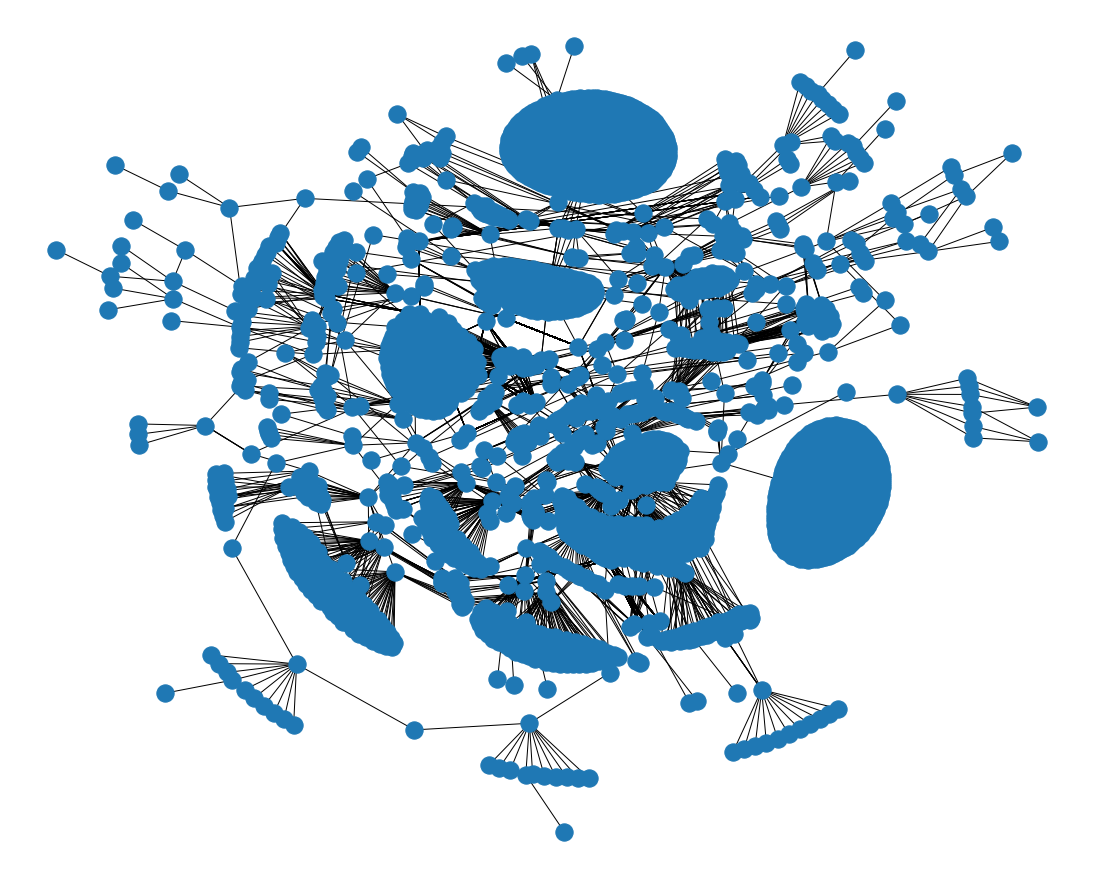

In [25]:
from matplotlib.pyplot import figure
figure(figsize=(15, 12))
nx.draw_kamada_kawai(graphs[0], with_labels=False)
plt.savefig("largest_connected_undirected_subgraph.png") # save as png
plt.show() # display

In [26]:
list(nx.isolates(G))

[]

In [27]:
#G.remove_nodes_from(list(nx.isolates(G)))

In [28]:
#G = G.to_undirected()
I = graphs[0]
I = nx.convert_node_labels_to_integers(I, first_label=0, ordering='default', label_attribute='Orig_Label')

In [29]:
#list(I.nodes(data=True))

In [30]:
#list(I.edges.data())

In [31]:
nx.is_connected(I)

True

## Test NetworkX Clustering

### Test community.best_partition

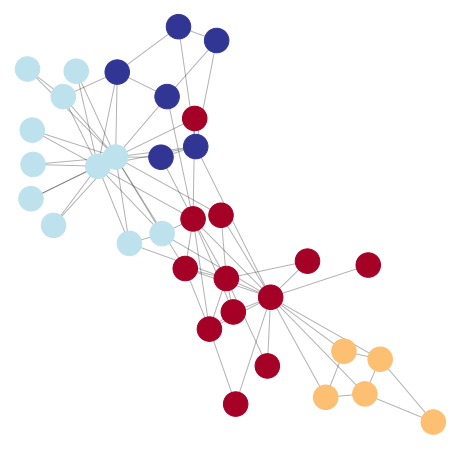

In [32]:
import networkx as nx
import community
import matplotlib.pyplot as plt

J = nx.karate_club_graph()  # load a default graph

partition = community.best_partition(J)  # compute communities

pos = nx.spring_layout(J)  # compute graph layout
plt.figure(figsize=(8, 8))  # image is 8 x 8 inches
plt.axis('off')
nx.draw_networkx_nodes(J, pos, node_size=600, cmap=plt.cm.RdYlBu, node_color=list(partition.values()))
nx.draw_networkx_edges(J, pos, alpha=0.3)
plt.show(J)

In [34]:
#partition

## Cluster with community.best_partition 

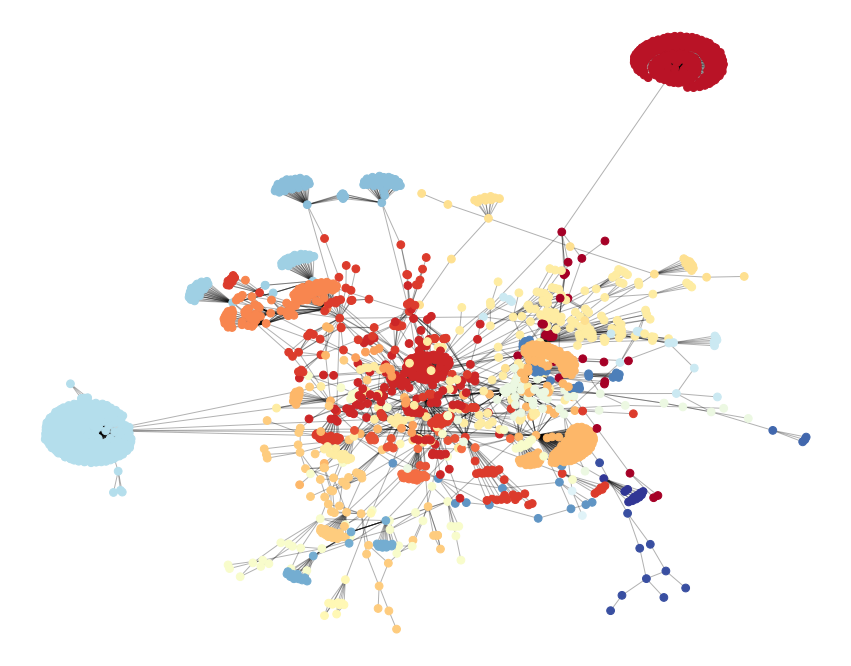

In [35]:
partition = community.best_partition(I)  # compute communities

pos = nx.spring_layout(I)  # compute graph layout
plt.figure(figsize=(15, 12))  # image is 8 x 8 inches
plt.axis('off')
nx.draw_networkx_nodes(I, pos, node_size=60, cmap=plt.cm.RdYlBu, node_color=list(partition.values()))
nx.draw_networkx_edges(I, pos, alpha=0.3)
plt.savefig("cluster1_spring.png") # save as png
plt.show(I)

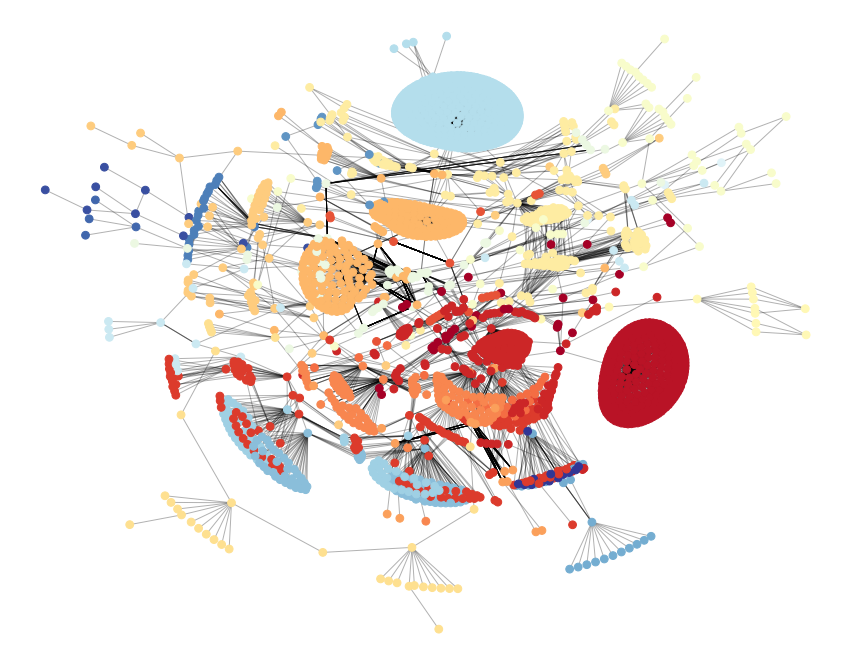

In [36]:
#partition = community.best_partition(I)  # compute communities

pos = nx.kamada_kawai_layout(I)  # compute graph layout
plt.figure(figsize=(15, 12))  # image is 8 x 8 inches
plt.axis('off')
nx.draw_networkx_nodes(I, pos, node_size=60, cmap=plt.cm.RdYlBu, node_color=list(partition.values()))
nx.draw_networkx_edges(I, pos, alpha=0.3)
plt.savefig("cluster1_kamada_kawai.png") # save as png
plt.show(I)

In [37]:
# 26 Communities
communities = set(partition.values())
len(communities)

26

In [38]:
starting_guid = '{47ab858c-e13c-5eac-a903-000000000400}'
for (p, d) in I.nodes(data=True):
    if 'process_guid' in d['properties'].keys():
        if starting_guid in d['properties']['process_guid']:
            selected_node = p
            break

In [39]:
selected_node

1342

## Cluster With Single Node

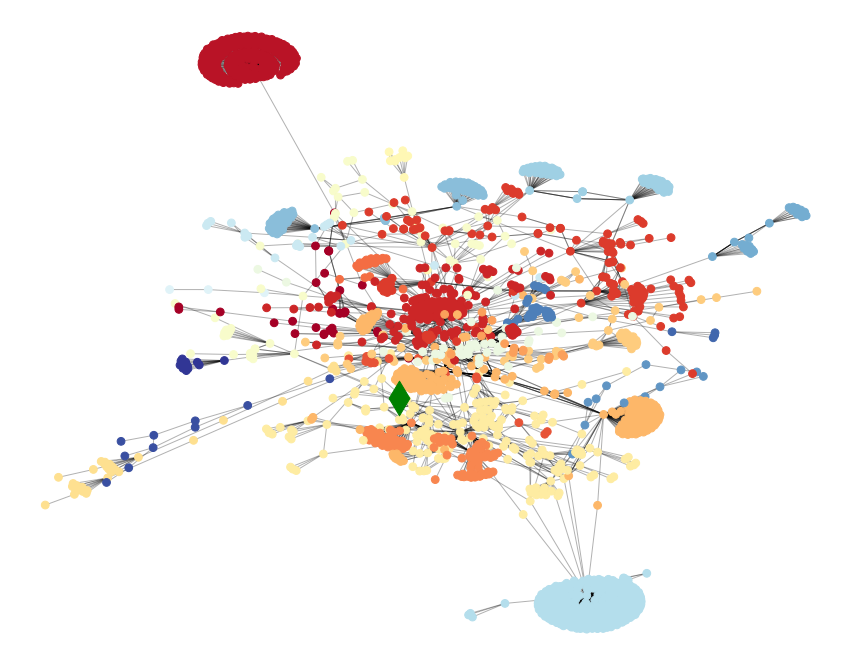

In [40]:
pos = nx.spring_layout(I)  # compute graph layout
plt.figure(figsize=(15, 12))  # image is 8 x 8 inches
plt.axis('off')
nx.draw_networkx_nodes(I, pos, node_size=60, cmap=plt.cm.RdYlBu, node_color=list(partition.values()))
nx.draw_networkx_nodes(I, pos,
                       nodelist=[selected_node],
                       node_size=600, node_color='g', node_shape='d',
                       label='selected_node')
nx.draw_networkx_edges(I, pos, alpha=0.3)
plt.savefig("cluster2_single_node_spring.png") # save as png
plt.show(I)

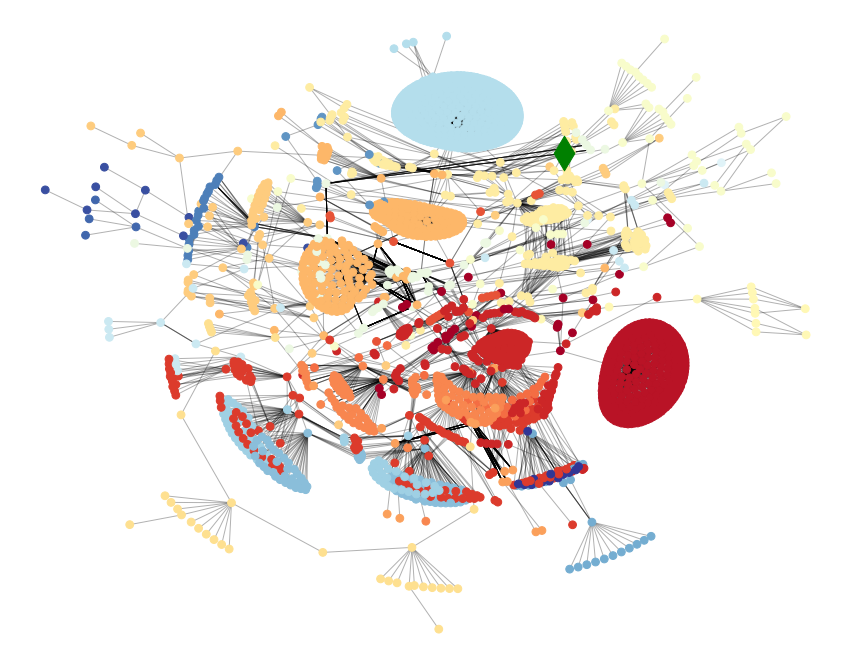

In [41]:
pos = nx.kamada_kawai_layout(I)  # compute graph layout
plt.figure(figsize=(15, 12))  # image is 8 x 8 inches
plt.axis('off')
nx.draw_networkx_nodes(I, pos, node_size=60, cmap=plt.cm.RdYlBu, node_color=list(partition.values()))
nx.draw_networkx_nodes(I, pos,
                       nodelist=[selected_node],
                       node_size=600, node_color='g', node_shape='d',
                       label='selected_node')
nx.draw_networkx_edges(I, pos, alpha=0.3)
plt.savefig("cluster2_single_node_kamada.png") # save as png
plt.show(I)

In [42]:
# So the selected node is in community 11
partition[selected_node]

11

### Malicious Subgraph

In [43]:
# Now determine the ancestor/descendant nodes around selected_node
K, malicious_root_ancestor, ancestors, descendants, file_nodes, proc_nodes, ip_nodes = manual_recurse_pipeline(G, '{47ab858c-e13c-5eac-a903-000000000400}')

Node Data:
{'properties': {'process_guid': '{47ab858c-dac4-5eac-f202-000000000400}', 'host': 'SCRANTON.dmevals.local', 'process_id': 4440, 'user': nan, 'process_image': 'Explorer.EXE', 'process_image_path': 'C:\\windows', 'command_line': None, 'hashes': {}, 'process_path': 'C:\\windows\\Explorer.EXE'}, '_node_type': 'Process', '_node_class': 'SysMonProc', '_display': 'Explorer.EXE', '_color': '#FF0000'}


Malicious? Enter yes or no:  no



##########################################
Confirm this as the senior malicious node?
##########################################
Node Data:
{'properties': {'process_guid': '{47ab858c-e13c-5eac-a903-000000000400}', 'host': 'SCRANTON.dmevals.local', 'process_id': 8524, 'user': nan, 'process_image': 'â€®cod.3aka3.scr', 'process_image_path': 'C:\\ProgramData\\victim', 'command_line': '"C:\\ProgramData\\victim\\â€®cod.3aka3.scr" /S', 'hashes': {'sha1': '4B7FA56A4E85F88B98D11A6E018698AE3FBA5E62', 'md5': '9D1C5EF38E6073661C74660B3A71A76E', 'sha256': '0DF38A55D940F498478EB03683C94D4584236E100125B526A67650BA54DF4AE4', 'imphash': 'F00447512A354E59D39D2818AABA4A17'}, 'process_path': 'C:\\ProgramData\\victim\\â€®cod.3aka3.scr'}, '_node_type': 'Process', '_node_class': 'SysMonProc', '_display': 'â€®cod.3aka3.scr', '_color': '#FF0000'}
Edge Out Data:
Launched
{'properties': {'process_guid': '{47ab858c-e188-5eac-af03-000000000400}', 'host': 'SCRANTON.dmevals.local', 'process_id': 3152, 'user': 'DMEV

Malicious? Enter yes or no:  yes


7308943545932794671
7308943545932794671
489
4
494


/home/jake/miniconda3/envs/py3msc/lib/python3.7/site-packages/networkx/drawing/nx_pylab.py:676: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  if cb.iterable(node_size):  # many node sizes


Saving as: ancestor_descendants_7308943545932794671.png


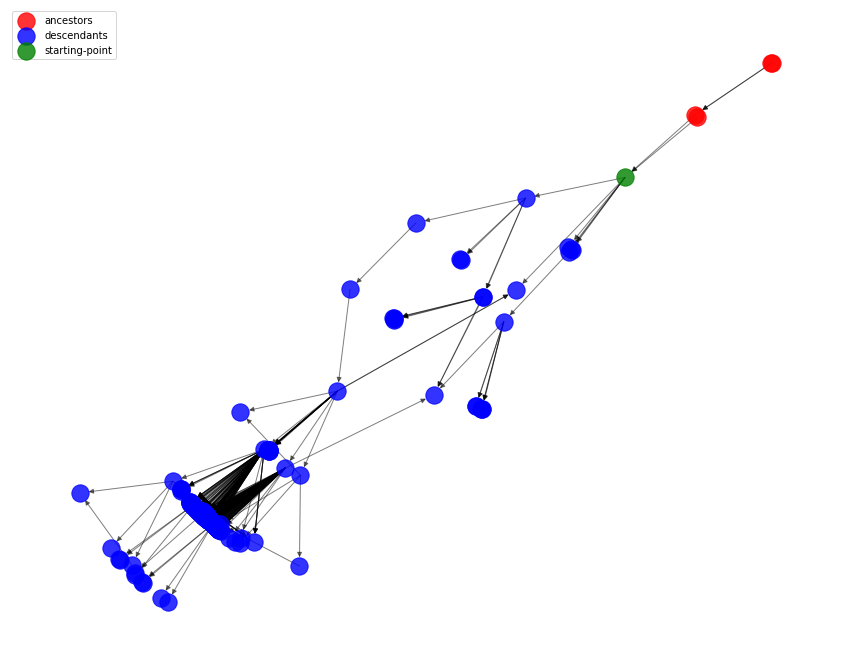

In [44]:
print_ancestor_descendant_graph(K, malicious_root_ancestor, ancestors, descendants)

Saving as: ancestor_descendants_nodeType_7308943545932794671.png


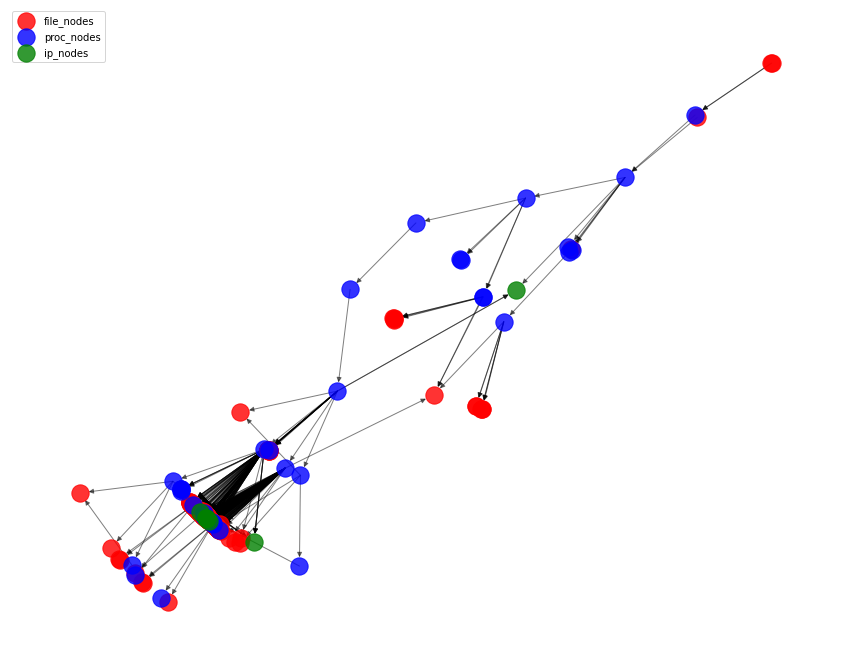

In [46]:
print_ancestor_descendant_type_graph(K, malicious_root_ancestor, file_nodes, proc_nodes, ip_nodes)

## Community Memberships

In [ ]:
# So I want the proc_nodes community memberships. Or first I'll go with all descendant nodes.

In [47]:
descendants

{-9211287028707770218,
 -9209410559668558418,
 -9205618740473122299,
 -9157049716059282446,
 -9141234886974006197,
 -9125040560704783428,
 -9123258288719441711,
 -9119484592386628205,
 -9087333722120823177,
 -9079811126849164687,
 -9038564964149416805,
 -8892333052361312447,
 -8883606530220245634,
 -8871465981108044888,
 -8719457323107207066,
 -8705708390635960395,
 -8633570363387877705,
 -8628249875077025251,
 -8579326450751760128,
 -8579059378236253946,
 -8569130418082404289,
 -8562872083174762496,
 -8553355950106656437,
 -8538084154552199542,
 -8486863886834994385,
 -8393921472154815003,
 -8377391619515511646,
 -8376308179856910853,
 -8359092071046104874,
 -8343818974235490645,
 -8267756803136204422,
 -8194051163898596260,
 -8118876211878768956,
 -8076844449924251993,
 -7995251068834983735,
 -7988421125294166861,
 -7978333248121253827,
 -7955892696165547426,
 -7942667555427676582,
 -7711944812328597849,
 -7702902886256151716,
 -7664972390685160985,
 -7584369215958712989,
 -750858237

In [48]:
proc_nodes_guids = []
for i in descendants:
    if 'process_guid' in H.node[i]['properties'].keys():
        proc_nodes_guids.append(H.node[i]['properties']['process_guid'])
#proc_nodes_guids
proc_nodes_nodeIDs = []
for (p, d) in I.nodes(data=True):
    if 'process_guid' in d['properties'].keys():
        if d['properties']['process_guid'] in proc_nodes_guids:
            proc_nodes_nodeIDs.append(p)

In [53]:
# So 11 seems to be a winner. At least there isn't a crazy number of communities in the descendants processes.
for i in proc_nodes_nodeIDs:
    print(str(i) + " : " + str(partition[i]))

186 : 11
207 : 11
213 : 11
219 : 11
222 : 11
224 : 11
226 : 11
279 : 17
280 : 8
281 : 11
283 : 11
284 : 11
286 : 11
287 : 11
288 : 11
687 : 17
688 : 17
689 : 17
690 : 17
823 : 8
824 : 8
825 : 8
826 : 8
827 : 21
906 : 21
980 : 11
985 : 11
1058 : 11
1059 : 11
1060 : 11
1061 : 11
1235 : 21
1238 : 21


## Cluster With Malicous Subgraph

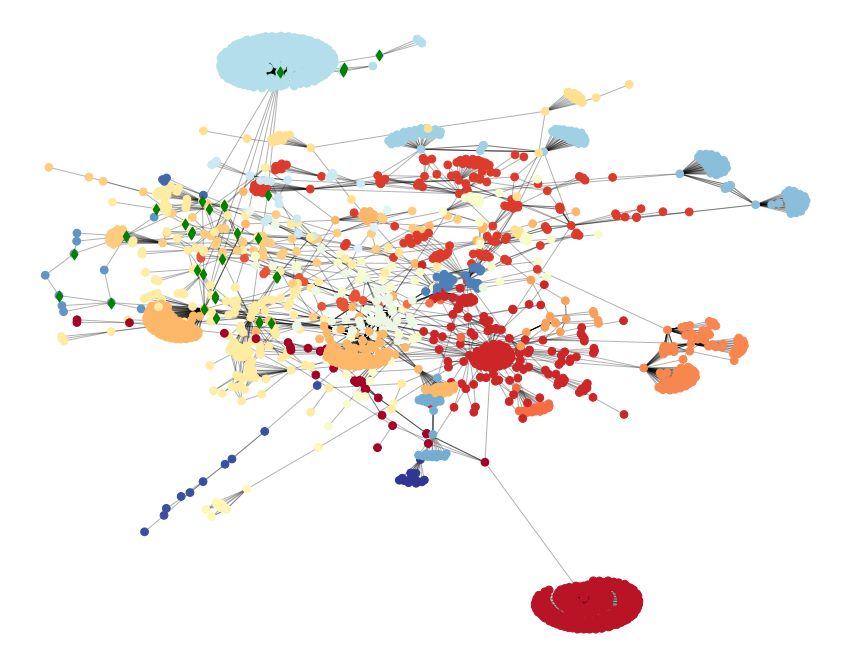

In [54]:
# That big light blue blob might be our winner cluster.
pos = nx.spring_layout(I)  # compute graph layout
plt.figure(figsize=(15, 12))  # image is 8 x 8 inches
plt.axis('off')
nx.draw_networkx_nodes(I, pos, node_size=60, cmap=plt.cm.RdYlBu, node_color=list(partition.values()))
nx.draw_networkx_nodes(I, pos,
                       nodelist=proc_nodes_nodeIDs,
                       node_size=60, node_color='g', node_shape='d',
                       label='selected_node')
nx.draw_networkx_edges(I, pos, alpha=0.3)
plt.savefig("cluster3_descendant_processes_spring.png") # save as png
plt.show(I)

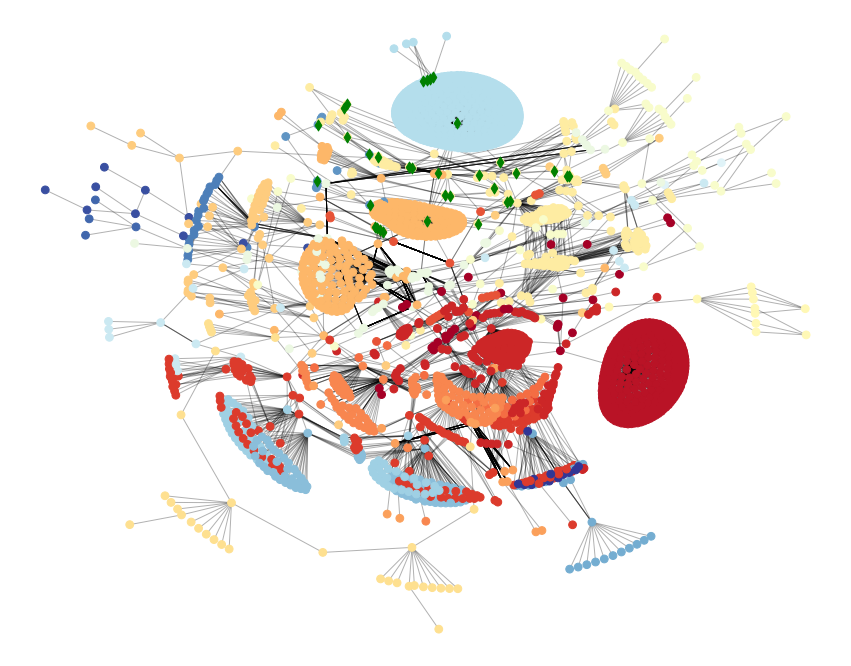

In [55]:
# That big light blue blob might be our winner cluster.
pos = nx.kamada_kawai_layout(I)  # compute graph layout
plt.figure(figsize=(15, 12))  # image is 8 x 8 inches
plt.axis('off')
nx.draw_networkx_nodes(I, pos, node_size=60, cmap=plt.cm.RdYlBu, node_color=list(partition.values()))
nx.draw_networkx_nodes(I, pos,
                       nodelist=proc_nodes_nodeIDs,
                       node_size=60, node_color='g', node_shape='d',
                       label='selected_node')
nx.draw_networkx_edges(I, pos, alpha=0.3)
plt.savefig("cluster3_descendant_processes_kamada_kawai_layout.png") # save as png
plt.show(I)

In [56]:
# 1975 communities? -> node count.
len(partition)

1975

In [57]:
# 26 Communities
uniqueValues = set(partition.values())
uniqueValues

{0,
 1,
 2,
 3,
 4,
 5,
 6,
 7,
 8,
 9,
 10,
 11,
 12,
 13,
 14,
 15,
 16,
 17,
 18,
 19,
 20,
 21,
 22,
 23,
 24,
 25}

In [58]:
nx.is_weakly_connected(G)

False

In [59]:
nx.is_strongly_connected(G)

False

## Node Centrality

In [60]:
nx.pagerank(I, alpha=0.9)

NetworkXNotImplemented: not implemented for multigraph type

In [62]:
c_degree = nx.degree_centrality(I)
len(c_degree)

1975

In [63]:
for i in proc_nodes_nodeIDs:
    print(str(i) + ":" + str(c_degree[i]))

186:0.0010131712259371835
207:0.0010131712259371835
213:0.0010131712259371835
219:0.0010131712259371835
222:0.0010131712259371835
224:0.0010131712259371835
226:0.0010131712259371835
279:0.1661600810536981
280:0.06585612968591692
281:0.011144883485309018
283:0.0030395136778115506
284:0.0030395136778115506
286:0.0030395136778115506
287:0.0025329280648429585
288:0.004559270516717326
687:0.002026342451874367
688:0.0010131712259371835
689:0.0010131712259371835
690:0.0010131712259371835
823:0.0015197568389057753
824:0.002026342451874367
825:0.0015197568389057753
826:0.0015197568389057753
827:0.0030395136778115506
906:0.0030395136778115506
980:0.003546099290780142
985:0.0015197568389057753
1058:0.0015197568389057753
1059:0.0010131712259371835
1060:0.0010131712259371835
1061:0.0015197568389057753
1235:0.0015197568389057753
1238:0.0015197568389057753


In [65]:
for i in proc_nodes_nodeIDs:
    #print(I.node[i])
    print(str(i) + ":" + str(c_degree[i]))

186:0.0010131712259371835
207:0.0010131712259371835
213:0.0010131712259371835
219:0.0010131712259371835
222:0.0010131712259371835
224:0.0010131712259371835
226:0.0010131712259371835
279:0.1661600810536981
280:0.06585612968591692
281:0.011144883485309018
283:0.0030395136778115506
284:0.0030395136778115506
286:0.0030395136778115506
287:0.0025329280648429585
288:0.004559270516717326
687:0.002026342451874367
688:0.0010131712259371835
689:0.0010131712259371835
690:0.0010131712259371835
823:0.0015197568389057753
824:0.002026342451874367
825:0.0015197568389057753
826:0.0015197568389057753
827:0.0030395136778115506
906:0.0030395136778115506
980:0.003546099290780142
985:0.0015197568389057753
1058:0.0015197568389057753
1059:0.0010131712259371835
1060:0.0010131712259371835
1061:0.0015197568389057753
1235:0.0015197568389057753
1238:0.0015197568389057753


In [67]:
# Process node with highest centrality
I.node[279]

{'properties': {'process_guid': '{47ab858c-e23d-5eac-c603-000000000400}',
  'host': 'SCRANTON.dmevals.local',
  'process_id': 3876,
  'user': nan,
  'process_image': 'powershell.exe',
  'process_image_path': 'C:\\windows\\system32\\WindowsPowerShell\\v1.0',
  'command_line': 'powershell.exe',
  'hashes': {'sha1': '36C5D12033B2EAF251BAE61C00690FFB17FDDC87',
   'md5': 'CDA48FC75952AD12D99E526D0B6BF70A',
   'sha256': '908B64B1971A979C7E3E8CE4621945CBA84854CB98D76367B791A6E22B5F6D53',
   'imphash': 'A7CEFACDDA74B13CD330390769752481'},
  'process_path': 'C:\\windows\\system32\\WindowsPowerShell\\v1.0\\powershell.exe'},
 '_node_type': 'Process',
 '_node_class': 'SysMonProc',
 '_display': 'powershell.exe',
 '_color': '#FF0000',
 'Orig_Label': 8481317032775075258}

In [68]:
c_degree_sorted = {k: v for k, v in sorted(c_degree.items(), key=lambda item: item[1], reverse=True)}

In [69]:
# Powershell processes are super busy.
for i in c_degree_sorted.items():
    if i[0] in proc_nodes_nodeIDs:
        print(i)
        print(I.node[i[0]])
        print("")

(279, 0.1661600810536981)
{'properties': {'process_guid': '{47ab858c-e23d-5eac-c603-000000000400}', 'host': 'SCRANTON.dmevals.local', 'process_id': 3876, 'user': nan, 'process_image': 'powershell.exe', 'process_image_path': 'C:\\windows\\system32\\WindowsPowerShell\\v1.0', 'command_line': 'powershell.exe', 'hashes': {'sha1': '36C5D12033B2EAF251BAE61C00690FFB17FDDC87', 'md5': 'CDA48FC75952AD12D99E526D0B6BF70A', 'sha256': '908B64B1971A979C7E3E8CE4621945CBA84854CB98D76367B791A6E22B5F6D53', 'imphash': 'A7CEFACDDA74B13CD330390769752481'}, 'process_path': 'C:\\windows\\system32\\WindowsPowerShell\\v1.0\\powershell.exe'}, '_node_type': 'Process', '_node_class': 'SysMonProc', '_display': 'powershell.exe', '_color': '#FF0000', 'Orig_Label': 8481317032775075258}

(280, 0.06585612968591692)
{'properties': {'process_guid': '{47ab858c-e374-5eac-d803-000000000400}', 'host': 'SCRANTON.dmevals.local', 'process_id': 3852, 'user': nan, 'process_image': 'powershell.exe', 'process_image_path': 'C:\\window

In [72]:
ancestors

{-8570813099847887304,
 -6369425012439087193,
 -3341595852200577503,
 8185097820786604332}

In [142]:
def translate_directed_to_undirected(H, I, directed_nodes):
    # H graph to I graph translation.
    proc_nodes_guids = []
    undirected_nodes = []
    file_nodes_full_paths = []
    ip_nodes_ip_addresses = []
    file_nodes_nodeIDs = []
    ip_nodes_nodeIDs = []

    if type(directed_nodes) == int:
        if 'process_guid' in H.node[directed_nodes]['properties'].keys():
                proc_nodes_guids.append(H.node[directed_nodes]['properties']['process_guid'])
        for (p, d) in I.nodes(data=True):
            if 'process_guid' in d['properties'].keys():
                if d['properties']['process_guid'] in proc_nodes_guids:
                    undirected_nodes.append(p)

        if 'full_path' in H.node[directed_nodes]['properties'].keys():
                file_nodes_full_paths.append(H.node[directed_nodes]['properties']['full_path'])
        for (p, d) in I.nodes(data=True):
            if 'full_path' in d['properties'].keys():
                if d['properties']['full_path'] in file_nodes_full_paths:
                    undirected_nodes.append(p)

        if 'ip_address' in H.node[directed_nodes]['properties'].keys():
                ip_nodes_ip_addresses.append(H.node[directed_nodes]['properties']['ip_address'])
        for (p, d) in I.nodes(data=True):
            if 'ip_address' in d['properties'].keys():
                if d['properties']['ip_address'] in ip_nodes_ip_addresses:
                    undirected_nodes.append(p)
        return undirected_nodes

    for i in directed_nodes:
        if 'process_guid' in H.node[i]['properties'].keys():
            proc_nodes_guids.append(H.node[i]['properties']['process_guid'])
    for (p, d) in I.nodes(data=True):
        if 'process_guid' in d['properties'].keys():
            if d['properties']['process_guid'] in proc_nodes_guids:
                undirected_nodes.append(p)

    for i in directed_nodes:
        if 'full_path' in H.node[i]['properties'].keys():
            file_nodes_full_paths.append(H.node[i]['properties']['full_path'])
    for (p, d) in I.nodes(data=True):
        if 'full_path' in d['properties'].keys():
            if d['properties']['full_path'] in file_nodes_full_paths:
                undirected_nodes.append(p)

    for i in directed_nodes:
        if 'ip_address' in H.node[i]['properties'].keys():
            ip_nodes_ip_addresses.append(H.node[i]['properties']['ip_address'])
    for (p, d) in I.nodes(data=True):
        if 'ip_address' in d['properties'].keys():
            if d['properties']['ip_address'] in ip_nodes_ip_addresses:
                undirected_nodes.append(p)
    return undirected_nodes

In [145]:
def translate_undirected_to_directed(H, I, directed_nodes):
    # H graph to I graph translation.
    proc_nodes_guids = []
    undirected_nodes = []
    file_nodes_full_paths = []
    ip_nodes_ip_addresses = []
    file_nodes_nodeIDs = []
    ip_nodes_nodeIDs = []

    if type(directed_nodes) == int:
        if 'process_guid' in I.node[directed_nodes]['properties'].keys():
                proc_nodes_guids.append(I.node[directed_nodes]['properties']['process_guid'])
        for (p, d) in H.nodes(data=True):
            if 'process_guid' in d['properties'].keys():
                if d['properties']['process_guid'] in proc_nodes_guids:
                    undirected_nodes.append(p)

        if 'full_path' in I.node[directed_nodes]['properties'].keys():
                file_nodes_full_paths.append(I.node[directed_nodes]['properties']['full_path'])
        for (p, d) in H.nodes(data=True):
            if 'full_path' in d['properties'].keys():
                if d['properties']['full_path'] in file_nodes_full_paths:
                    undirected_nodes.append(p)

        if 'ip_address' in I.node[directed_nodes]['properties'].keys():
                ip_nodes_ip_addresses.append(I.node[directed_nodes]['properties']['ip_address'])
        for (p, d) in H.nodes(data=True):
            if 'ip_address' in d['properties'].keys():
                if d['properties']['ip_address'] in ip_nodes_ip_addresses:
                    undirected_nodes.append(p)
        return undirected_nodes

    for i in directed_nodes:
        if 'process_guid' in I.node[i]['properties'].keys():
            proc_nodes_guids.append(I.node[i]['properties']['process_guid'])
    for (p, d) in H.nodes(data=True):
        if 'process_guid' in d['properties'].keys():
            if d['properties']['process_guid'] in proc_nodes_guids:
                undirected_nodes.append(p)

    for i in directed_nodes:
        if 'full_path' in I.node[i]['properties'].keys():
            file_nodes_full_paths.append(I.node[i]['properties']['full_path'])
    for (p, d) in H.nodes(data=True):
        if 'full_path' in d['properties'].keys():
            if d['properties']['full_path'] in file_nodes_full_paths:
                undirected_nodes.append(p)

    for i in directed_nodes:
        if 'ip_address' in I.node[i]['properties'].keys():
            ip_nodes_ip_addresses.append(I.node[i]['properties']['ip_address'])
    for (p, d) in H.nodes(data=True):
        if 'ip_address' in d['properties'].keys():
            if d['properties']['ip_address'] in ip_nodes_ip_addresses:
                undirected_nodes.append(p)
    return undirected_nodes

In [73]:
undirected_ancestors = translate_directed_to_undirected(ancestors)

In [74]:
len(undirected_ancestors)

4

In [81]:
df_ancestors = pd.DataFrame(undirected_ancestors, columns=['NodeID'])
df_ancestors['CentralityDegree'] = np.nan
#df_ancestors['CentralityDegree'] = c_degree[df_ancestors.NodeID]
df_ancestors

NodeID  CentralityDegree
0    1434               NaN
1    1344               NaN
2    1433               NaN
3    1954               NaN

In [159]:
c_degree = nx.degree_centrality(I)
len(c_degree)

df = pd.DataFrame.from_dict(dict(I.nodes(data=True)), orient='index')
df = pd.concat([df.drop(['properties'], axis=1), df['properties'].apply(pd.Series)], axis=1)
df = df.reset_index().rename(columns={"index" : "UnDirNodeID"})
df = df.rename(columns={"Orig_Label" : "DirNode"})
df['DegreeCentrality'] =  df['UnDirNodeID'].apply(lambda x: (c_degree[x]))
#df.sort_values(by=['DegreeCentrality'], ascending=False)
df.loc[df.UnDirNodeID.isin(list(translate_directed_to_undirected(H, I, malicious_root_ancestor)) + list(translate_directed_to_undirected(H, I, ancestors)))] #[['_display', 'DegreeCentrality']]

UnDirNodeID _node_type _node_class          _display   _color  \
1342         1342    Process  SysMonProc  â€®cod.3aka3.scr  #FF0000   
1344         1344       File        File  â€®cod.3aka3.scr  #3CB371   
1433         1433       File        File      explorer.exe  #3CB371   
1434         1434    Process  SysMonProc      Explorer.EXE  #FF0000   
1954         1954       File        File      Explorer.EXE  #3CB371   

                  DirNode                            process_guid  \
1342  7308943545932794671  {47ab858c-e13c-5eac-a903-000000000400}   
1344 -6369425012439087193                                     NaN   
1433  8185097820786604332                                     NaN   
1434 -8570813099847887304  {47ab858c-dac4-5eac-f202-000000000400}   
1954 -3341595852200577503                                     NaN   

                        host  process_id user     process_image  \
1342  SCRANTON.dmevals.local      8524.0  NaN  â€®cod.3aka3.scr   
1344  SCRANTON.dmevals.local         NaN  NaN               NaN   
1433  SCRANTON.dmevals.local         NaN  NaN               NaN   
1434  SCRANTON.dmevals.local      4440.0  NaN      Explorer.EXE   
1954  SCRANTON.dmevals.local         NaN  NaN               NaN   

         process_image_path                                 command_line  \
1342  C:\ProgramData\victim  "C:\ProgramData\victim\â€®cod.3aka3.scr" /S   
1344                    NaN                                          NaN   
1433                    NaN                                          NaN   
1434             C:\windows                                         None   
1954                    NaN                                          NaN   

                                                                                                                                                                                                                            hashes  \
1342  {'sha1': '4B7FA56A4E85F88B98D11A6E018698AE3FBA5E62', 'md5': '9D1C5EF38E6073661C74660B3A71A76E', 'sha256': '0DF38A55D940F498478EB03683C94D4584236E100125B526A67650BA54DF4AE4', 'imphash': 'F00447512A354E59D39D2818AABA4A17'}   
1344  {'sha1': '4B7FA56A4E85F88B98D11A6E018698AE3FBA5E62', 'md5': '9D1C5EF38E6073661C74660B3A71A76E', 'sha256': '0DF38A55D940F498478EB03683C94D4584236E100125B526A67650BA54DF4AE4', 'imphash': 'F00447512A354E59D39D2818AABA4A17'}   
1433  {'sha1': 'C893CF07E5F65749CD66E17D9523638B132C87B2', 'md5': 'F7DC8A74E30E08B9510380274CFB9288', 'sha256': 'C5E88D778C0B118D49BEF467ED059C09B61DEEA505D2A3D5CA1DCC0A5CDF752F', 'imphash': 'FE6F775DD0C72FFD106F56930C60A452'}   
1434                                                                                                                                                                                                                            {}   
1954                                                                                                                                                                                                                            {}   

                                process_path              file_path  \
1342  C:\ProgramData\victim\â€®cod.3aka3.scr                    NaN   
1344                                     NaN  C:\ProgramData\victim   
1433                                     NaN             C:\Windows   
1434                 C:\windows\Explorer.EXE                    NaN   
1954                                     NaN             C:\windows   

             file_name                               full_path  extension  \
1342               NaN                                     NaN        NaN   
1344  â€®cod.3aka3.scr  C:\ProgramData\victim\â€®cod.3aka3.scr        NaN   
1433      explorer.exe                 C:\Windows\explorer.exe        NaN   
1434               NaN                                     NaN        NaN   
1954      Explorer.EXE                 C:\windows\Explorer.EXE        NaN   

     ip_address  mac  DegreeCentr

In [160]:
df.loc[df.DirNode.isin([malicious_root_ancestor] + list(ancestors))] #[['_display', 'DegreeCentrality']]

UnDirNodeID _node_type _node_class          _display   _color  \
1342         1342    Process  SysMonProc  â€®cod.3aka3.scr  #FF0000   
1344         1344       File        File  â€®cod.3aka3.scr  #3CB371   
1433         1433       File        File      explorer.exe  #3CB371   
1434         1434    Process  SysMonProc      Explorer.EXE  #FF0000   
1954         1954       File        File      Explorer.EXE  #3CB371   

                  DirNode                            process_guid  \
1342  7308943545932794671  {47ab858c-e13c-5eac-a903-000000000400}   
1344 -6369425012439087193                                     NaN   
1433  8185097820786604332                                     NaN   
1434 -8570813099847887304  {47ab858c-dac4-5eac-f202-000000000400}   
1954 -3341595852200577503                                     NaN   

                        host  process_id user     process_image  \
1342  SCRANTON.dmevals.local      8524.0  NaN  â€®cod.3aka3.scr   
1344  SCRANTON.dmevals.local         NaN  NaN               NaN   
1433  SCRANTON.dmevals.local         NaN  NaN               NaN   
1434  SCRANTON.dmevals.local      4440.0  NaN      Explorer.EXE   
1954  SCRANTON.dmevals.local         NaN  NaN               NaN   

         process_image_path                                 command_line  \
1342  C:\ProgramData\victim  "C:\ProgramData\victim\â€®cod.3aka3.scr" /S   
1344                    NaN                                          NaN   
1433                    NaN                                          NaN   
1434             C:\windows                                         None   
1954                    NaN                                          NaN   

                                                                                                                                                                                                                            hashes  \
1342  {'sha1': '4B7FA56A4E85F88B98D11A6E018698AE3FBA5E62', 'md5': '9D1C5EF38E6073661C74660B3A71A76E', 'sha256': '0DF38A55D940F498478EB03683C94D4584236E100125B526A67650BA54DF4AE4', 'imphash': 'F00447512A354E59D39D2818AABA4A17'}   
1344  {'sha1': '4B7FA56A4E85F88B98D11A6E018698AE3FBA5E62', 'md5': '9D1C5EF38E6073661C74660B3A71A76E', 'sha256': '0DF38A55D940F498478EB03683C94D4584236E100125B526A67650BA54DF4AE4', 'imphash': 'F00447512A354E59D39D2818AABA4A17'}   
1433  {'sha1': 'C893CF07E5F65749CD66E17D9523638B132C87B2', 'md5': 'F7DC8A74E30E08B9510380274CFB9288', 'sha256': 'C5E88D778C0B118D49BEF467ED059C09B61DEEA505D2A3D5CA1DCC0A5CDF752F', 'imphash': 'FE6F775DD0C72FFD106F56930C60A452'}   
1434                                                                                                                                                                                                                            {}   
1954                                                                                                                                                                                                                            {}   

                                process_path              file_path  \
1342  C:\ProgramData\victim\â€®cod.3aka3.scr                    NaN   
1344                                     NaN  C:\ProgramData\victim   
1433                                     NaN             C:\Windows   
1434                 C:\windows\Explorer.EXE                    NaN   
1954                                     NaN             C:\windows   

             file_name                               full_path  extension  \
1342               NaN                                     NaN        NaN   
1344  â€®cod.3aka3.scr  C:\ProgramData\victim\â€®cod.3aka3.scr        NaN   
1433      explorer.exe                 C:\Windows\explorer.exe        NaN   
1434               NaN                                     NaN        NaN   
1954      Explorer.EXE                 C:\windows\Explorer.EXE        NaN   

     ip_address  mac  DegreeCentr

## Graph Types

In [187]:
G = json_graph.node_link_graph(graph_json)

In [167]:
L = nx.DiGraph(G)

In [174]:
cluster_coef = nx.algorithms.cluster.clustering(L)
len(cluster_coef)

2054

In [170]:
c_degree = nx.degree_centrality(L)
len(c_degree)

2054

In [180]:
an_degree = nx.algorithms.assortativity.average_neighbor_degree(G)
len(an_degree)
#an_degree

2054

In [183]:
import community
# requires undirected graph
best_partition = community.best_partition(H)  # compute communities
len(best_partition)

2054

In [185]:
#from networkx.algorithms.community import k_clique_communities
#kc_communities = k_clique_communities(G, k=3)

In [219]:
import networkx.algorithms.community as community
#c = greedy_modularity_communities(H)
greedy_communities = sorted(community.greedy_modularity_communities(H), key=len, reverse=True)
print(f"The graph has {len(communities)} communities.")

The graph has 26 communities.


In [220]:
# https://orbifold.net/default/community-detection-using-networkx/
def set_node_community(G, communities, method):
    '''Add community to node attributes'''
    for c, v_c in enumerate(communities):
        for v in v_c:
            # Add 1 to save 0 for external edges
            G.nodes[v][method] = c + 1

def set_edge_community(G, method):
    '''Find internal edges and add their community to their attributes'''
    for v, w, in G.edges:
        if G.nodes[v][method] == G.nodes[w][method]:
            # Internal edge, mark with community
            G.edges[v, w][method] = G.nodes[v][method]
        else:
            # External edge, mark as 0
            G.edges[v, w][method] = 0

In [221]:
# Set node and edge communities
set_node_community(L, greedy_communities, 'Greedy_Mod')

In [229]:
# https://programminghistorian.org/en/lessons/exploring-and-analyzing-network-data-with-python
betweenness_dict = nx.betweenness_centrality(L) # Run betweenness centrality

#PowerIterationFailedConvergence: (PowerIterationFailedConvergence(...), 'power iteration failed to converge within 100 iterations')
#eigenvector_dict = nx.eigenvector_centrality(L) # Run eigenvector centrality

# Assign each to an attribute in your network
nx.set_node_attributes(L, betweenness_dict, 'betweenness')
#nx.set_node_attributes(L, eigenvector_dict, 'eigenvector')

In [233]:
from networkx.algorithms import community
communities = community.greedy_modularity_communities(H)

modularity_dict = {} # Create a blank dictionary
for i,c in enumerate(communities): # Loop through the list of communities, keeping track of the number for the community
    for name in c: # Loop through each person in a community
        modularity_dict[name] = i # Create an entry in the dictionary for the person, where the value is which group they belong to.

# Now you can add modularity information like we did the other metrics
nx.set_node_attributes(L, modularity_dict, 'Greedy_Mod')

In [237]:
# Quick.
communities = community.label_propagation_communities(H)

label_prop_dict = {} # Create a blank dictionary
for i,c in enumerate(communities): # Loop through the list of communities, keeping track of the number for the community
    for name in c: # Loop through each person in a community
        label_prop_dict[name] = i # Create an entry in the dictionary for the person, where the value is which group they belong to.

# Now you can add modularity information like we did the other metrics
nx.set_node_attributes(L, label_prop_dict, 'label_prop')

## Cluster Analysis - DataFrame

In [241]:
df = pd.DataFrame.from_dict(dict(L.nodes(data=True)), orient='index')
df = pd.concat([df.drop(['properties'], axis=1), df['properties'].apply(pd.Series)], axis=1)
df = df.reset_index().rename(columns={"index" : "NodeID"})
df['DegreeCentrality'] =  df['NodeID'].apply(lambda x: (c_degree[x]))
df['ClusterCoef'] =  df['NodeID'].apply(lambda x: (cluster_coef[x]))
df['BestPartition'] = df['NodeID'].apply(lambda x: (best_partition[x]))
df['AveNeighDegree'] = df['NodeID'].apply(lambda x: (an_degree[x]))

df.head()

NodeID _node_type _node_class       _display   _color  \
0  5560320793766324432    Process  SysMonProc    svchost.exe  #FF0000   
1 -5098513601814409719    Process  SysMonProc  taskhostw.exe  #FF0000   
2   568672525942215723    Process  SysMonProc   gpupdate.exe  #FF0000   
3  2723077553381010090    Process  SysMonProc  taskhostw.exe  #FF0000   
4  9075240013458189115    Process  SysMonProc  taskhostw.exe  #FF0000   

   Greedy_Mod   betweenness  label_prop  \
0          11  6.076782e-05         124   
1          11  0.000000e+00         124   
2          11  7.121229e-07         149   
3          11  0.000000e+00         124   
4          11  0.000000e+00         124   

                             process_guid                    host  process_id  \
0  {47ab858c-cadc-5eac-2200-000000000400}  SCRANTON.dmevals.local      1448.0   
1  {47ab858c-e589-5eac-f803-000000000400}  SCRANTON.dmevals.local      8288.0   
2  {47ab858c-e296-5eac-c803-000000000400}  SCRANTON.dmevals.local       760.0   
3  {47ab858c-e2d4-5eac-cd03-000000000400}  SCRANTON.dmevals.local      8532.0   
4  {47ab858c-e37a-5eac-e003-000000000400}  SCRANTON.dmevals.local      1548.0   

                           user  process_image   process_image_path  \
0                          None    svchost.exe  C:\Windows\System32   
1               DMEVALS\pbeesly  taskhostw.exe  C:\Windows\System32   
2  NT AUTHORITY\NETWORK SERVICE   gpupdate.exe  C:\Windows\System32   
3               DMEVALS\pbeesly  taskhostw.exe  C:\Windows\System32   
4               DMEVALS\pbeesly  taskhostw.exe  C:\Windows\System32   

                    command_line  \
0                           None   
1  taskhostw.exe Install $(Arg0)   
2  gpupdate.exe /target:computer   
3  taskhostw.exe Install $(Arg0)   
4            taskhostw.exe Event   

                                                                                                                                                                                                                         hashes  \
0                                                                                                                                                                                                                            {}   
1  {'sha1': '9245F36AA783167E0AFE948B1C0E8E7F3B81E3D4', 'md5': '8AC325C757FA721B272ECEA19EBCF745', 'sha256': '0BEC3128B241FA533DC5A9D3F62AA41323D205DEFC30DCDE228C5ECC2D1E50A9', 'imphash': '9CB27CAED52CB0AFFB32788922A0D083'}   
2  {'sha1': '1529CB7F7DFA798337F781A71B583371E1D43F2B', 'md5': 'D4F01BEC9CA921C13ED1BDD1BF1D2D24', 'sha256': 'FE428F64B6920CBD542BF7097F009A576673888967CB5AE8803D310667ED428D', 'imphash': '874ADC3991B152C2F8C8ABC6E3F65A5C'}   
3  {'sha1': '9245F36AA783167E0AFE948B1C0E8E7F3B81E3D4', 'md5': '8AC325C757FA721B272ECEA19EBCF745', 'sha256': '0BEC3128B241FA533DC5A9D3F62AA41323D205DEFC30DCDE228C5ECC2D1E50A9', 'imphash': '9CB27CAED52CB0AFFB32788922A0D083'}   
4  {'sha1': '9245F36AA783167E0AFE948B1C0E8E7F3B81E3D4', 'md5': '8AC325C757FA721B272ECEA19EBCF745', 'sha256': '0BEC3128B241FA533DC5A9D3F62AA41323D205DEFC30DCDE228C5ECC2D1E50A9', 'imphash': '9CB27CAED52CB0AFFB32788922A0D083'}   

                        process_path file_path file_name full_path  extension  \
0    C:\Windows\System32\svchost.exe       NaN       NaN       NaN        NaN   
1  C:\Windows\System32\taskhostw.exe       NaN       NaN       NaN        NaN   
2   C:\Windows\System32\gpupdate.exe       NaN       NaN       NaN        NaN   
3  C:\Windows\System32\taskhostw.exe       NaN       NaN       NaN        NaN   
4  C:\Windows\System32\taskhostw.exe       NaN       NaN       NaN        NaN   

  ip_address  mac  DegreeCentrality  ClusterCoef  BestPartition  \
0        NaN  NaN          0.003410          0.0              0   
1        NaN  NaN          0.000974          0.0              0   
2        NaN  NaN          0.001461          0.0              0   
3        NaN  NaN          0.000974          0.0              0   
4 

In [270]:
df['Chain_Loc'] = np.nan
df['Chain_Loc'].loc[df.NodeID.isin(list(ancestors))] = '1_Ancestor' #[['_display', 'DegreeCentrality']]
df['Chain_Loc'].loc[df.NodeID.isin([malicious_root_ancestor])] = '2_Root' #[['_display', 'DegreeCentrality']]
df['Chain_Loc'].loc[df.NodeID.isin(list(descendants))] = '3_Descendant' #[['_display', 'DegreeCentrality']]
df.loc[((df['Chain_Loc']=='1_Ancestor') | (df['Chain_Loc']=='2_Root') | ((df['Chain_Loc']=='3_Descendant') & (df['_node_type']=='Process')))].sort_values(by=['Chain_Loc'], ascending=True)[['_display', '_node_type', 'Chain_Loc', 'BestPartition', 'Greedy_Mod', 'label_prop', 'process_path', 'betweenness', 'DegreeCentrality', 'ClusterCoef', 'AveNeighDegree']]

/home/jake/miniconda3/envs/py3msc/lib/python3.7/site-packages/pandas/core/indexing.py:671: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)


_display _node_type     Chain_Loc  BestPartition  Greedy_Mod  \
2028      Explorer.EXE       File    1_Ancestor             13           9   
1367  â€®cod.3aka3.scr       File    1_Ancestor             11           4   
1461      Explorer.EXE    Process    1_Ancestor             13           9   
1460      explorer.exe       File    1_Ancestor             13           9   
1365  â€®cod.3aka3.scr    Process        2_Root             11           4   
1256        cvtres.exe    Process  3_Descendant             23           5   
1253        cvtres.exe    Process  3_Descendant             23           5   
1076       control.exe    Process  3_Descendant             11           5   
1075         sdclt.exe    Process  3_Descendant             11           4   
1074         sdclt.exe    Process  3_Descendant             11           4   
836       PsExec64.exe    Process  3_Descendant              8           5   
998            cmd.exe    Process  3_Descendant             11           4   
993            cmd.exe    Process  3_Descendant             11           4   
919            csc.exe    Process  3_Descendant             23           5   
840            csc.exe    Process  3_Descendant             23           5   
839       PsExec64.exe    Process  3_Descendant              8           5   
838       PsExec64.exe    Process  3_Descendant              8           5   
837       PsExec64.exe    Process  3_Descendant              8           5   
1073         sdclt.exe    Process  3_Descendant             11           4   
186        conhost.exe    Process  3_Descendant             11           5   
688      sdelete64.exe    Process  3_Descendant             17           0   
207        conhost.exe    Process  3_Descendant             11           4   
213        conhost.exe    Process  3_Descendant             11           4   
219        conhost.exe    Process  3_Descendant             11           5   
222        conhost.exe    Process  3_Descendant             11           4   
224        conhost.exe    Process  3_Descendant             11           4   
226        conhost.exe    Process  3_Descendant             11           4   
279     powershell.exe    Process  3_Descendant             17           0   
280     powershell.exe    Process  3_Descendant              8           5   
281     PowerShell.exe    Process  3_Descendant             11           5   
283     powershell.exe    Process  3_Descendant             11           4   
284     powershell.exe    Process  3_Descendant             11           4   
286     powershell.exe    Process  3_Descendant             11           4   
287     powershell.exe    Process  3_Descendant             11           4   
288     powershell.exe    Process  3_Descendant             11           4   
687      accesschk.exe    Process  3_Descendant             17           0   
689      sdelete64.exe    Process  3_Descendant             17           0   
690      sdelete64.exe    Process  3_Descendant             17           0   

      label_prop                                                process_path  \
2028         187                                                         NaN   
1367         116                                                         NaN   
1461         187                                     C:\windows\Explorer.EXE   
1460         187                                                         NaN   
1365         116                      C:\ProgramData\victim\â€®cod.3aka3.scr   
1256         105  C:\Windows\Microsoft.NET\Framework64\v4.0.30319\cvtres.exe   
1253          74  C:\Windows\Microsoft.NET\Framework64\v4.0.30319\cvtres.exe   
1076          16                             C:\Windows\System32\control.exe   
1075          17                               C:\Windows\System32\sdclt.exe   
1074          17                               C:\Windows\System32\sdclt.exe   
836          118             C:\Program Files\SysinternalsSuite\PsExec64.exe   
998        

In [262]:
df.loc[((df['Chain_Loc']=='2_Root') | (df['Chain_Loc']=='3_Descendant')) & (df['_node_type']=='Process')]['Greedy_Mod'].value_counts()

4    16
5    13
0     5
Name: Greedy_Mod, dtype: int64

In [265]:
# Community 4 shows up a lot outside of the descendant graph.
# Community 5 shows up just once outside.
df.loc[(df['_node_type']=='Process') & (df['Greedy_Mod'].isin([9, 4, 5, 0]))]['Greedy_Mod'].value_counts()

4    111
9     26
5     14
0      5
Name: Greedy_Mod, dtype: int64

In [266]:
df.loc[(df['Greedy_Mod'].isin([9, 4, 5, 0]))]['Greedy_Mod'].value_counts()

0    327
4    174
5    138
9     56
Name: Greedy_Mod, dtype: int64

In [271]:
# Check those 4's
# Seems to be collection of core binaries. Plus the root malicious process strangely.
with pd.option_context('display.max_rows', None, 'display.max_columns', None, 'display.max_colwidth', None):
    display(df.loc[(df['_node_type']=='Process') & (df['Greedy_Mod'].isin([4]))][['_display', '_node_type', 'Chain_Loc', 'BestPartition', 'Greedy_Mod', 'label_prop', 'process_path', 'betweenness', 'DegreeCentrality', 'ClusterCoef', 'AveNeighDegree']])

_display _node_type     Chain_Loc  \
130           WindowsAzureNetAgent.exe    Process           NaN   
132         WindowsAzureGuestAgent.exe    Process           NaN   
134            NetworkWatcherAgent.exe    Process           NaN   
135   WindowsAzureTelemetryService.exe    Process           NaN   
139                     WaAppAgent.exe    Process           NaN   
179                          ROUTE.EXE    Process           NaN   
180                        conhost.exe    Process           NaN   
182                          ROUTE.EXE    Process           NaN   
183                          ROUTE.EXE    Process           NaN   
185                        conhost.exe    Process           NaN   
187                        conhost.exe    Process           NaN   
188                        conhost.exe    Process           NaN   
189                        conhost.exe    Process           NaN   
190                        conhost.exe    Process           NaN   
191                        conhost.exe    Process           NaN   
193                        conhost.exe    Process           NaN   
194                        conhost.exe    Process           NaN   
195                        conhost.exe    Process           NaN   
196                        conhost.exe    Process           NaN   
198                        conhost.exe    Process           NaN   
199                        conhost.exe    Process           NaN   
200                        conhost.exe    Process           NaN   
201                        conhost.exe    Process           NaN   
202                        conhost.exe    Process           NaN   
203                        conhost.exe    Process           NaN   
204                        conhost.exe    Process           NaN   
205                        conhost.exe    Process           NaN   
206                        conhost.exe    Process           NaN   
207                        conhost.exe    Process  3_Descendant   
208                        conhost.exe    Process           NaN   
209                        conhost.exe    Process           NaN   
210                        conhost.exe    Process           NaN   
211                        conhost.exe    Process           NaN   
212                        conhost.exe    Process           NaN   
213                        conhost.exe    Process  3_Descendant   
214                        conhost.exe    Process           NaN   
215                        conhost.exe    Process           NaN   
216                        conhost.exe    Process           NaN   
217                        conhost.exe    Process           NaN   
218                        conhost.exe    Process           NaN   
220                        conhost.exe    Process           NaN   
221                        conhost.exe    Process           NaN   
222                        conhost.exe    Process  3_Descendant   
223                        conhost.exe    Process           NaN   
224                        conhost.exe    Process  3_Descendant   
225                        conhost.exe    Process           NaN   
226                        conhost.exe    Process  3_Descendant   
227                        conhost.exe    Process           NaN   
228                        conhost.exe    Process           NaN   
230                        conhost.exe    Process           NaN   
231                        conhost.exe    Process           NaN   
232                        conhost.exe    Process           NaN   
233                        conhost.exe    Process           NaN   
234                        conhost.exe    Process           NaN   
246                             sc.exe    Process           NaN   
247                       wevtutil.exe    Process           NaN   
248                         logman.exe    Process           NaN   
249                 WaSecAgentProv.exe    Process           NaN   
250                 WaSecAgentProv.exe    Process           NaN   
251       

In [272]:
# Check 5's
with pd.option_context('display.max_rows', None, 'display.max_columns', None, 'display.max_colwidth', None):
    display(df.loc[(df['_node_type']=='Process') & (df['Greedy_Mod'].isin([5]))][['_display', '_node_type', 'Chain_Loc', 'BestPartition', 'Greedy_Mod', 'label_prop', 'process_path', 'betweenness', 'DegreeCentrality', 'ClusterCoef', 'AveNeighDegree']])

_display _node_type     Chain_Loc  BestPartition  Greedy_Mod  \
123      svchost.exe    Process           NaN              8           5   
186      conhost.exe    Process  3_Descendant             11           5   
219      conhost.exe    Process  3_Descendant             11           5   
280   powershell.exe    Process  3_Descendant              8           5   
281   PowerShell.exe    Process  3_Descendant             11           5   
836     PsExec64.exe    Process  3_Descendant              8           5   
837     PsExec64.exe    Process  3_Descendant              8           5   
838     PsExec64.exe    Process  3_Descendant              8           5   
839     PsExec64.exe    Process  3_Descendant              8           5   
840          csc.exe    Process  3_Descendant             23           5   
919          csc.exe    Process  3_Descendant             23           5   
1076     control.exe    Process  3_Descendant             11           5   
1253      cvtres.exe    Process  3_Descendant             23           5   
1256      cvtres.exe    Process  3_Descendant             23           5   

      label_prop                                                process_path  \
123          118                             C:\Windows\System32\svchost.exe   
186           96                             C:\Windows\System32\conhost.exe   
219           97                             C:\Windows\System32\conhost.exe   
280           96   C:\windows\system32\WindowsPowerShell\v1.0\powershell.exe   
281           97   C:\windows\system32\WindowsPowerShell\v1.0\PowerShell.exe   
836          118             C:\Program Files\SysinternalsSuite\PsExec64.exe   
837          118             C:\Program Files\SysinternalsSuite\PsExec64.exe   
838          118             C:\Program Files\SysinternalsSuite\PsExec64.exe   
839          118             C:\Program Files\SysinternalsSuite\PsExec64.exe   
840          105     C:\Windows\Microsoft.NET\Framework64\v4.0.30319\csc.exe   
919           72     C:\Windows\Microsoft.NET\Framework64\v4.0.30319\csc.exe   
1076          16                             C:\Windows\System32\control.exe   
1253          74  C:\Windows\Microsoft.NET\Framework64\v4.0.30319\cvtres.exe   
1256         105  C:\Windows\Microsoft.NET\Framework64\v4.0.30319\cvtres.exe   

       betweenness  DegreeCentrality  ClusterCoef  AveNeighDegree  
123   2.373743e-07          0.000974     0.000000        0.000000  
186   0.000000e+00          0.000974     0.000000        0.000000  
219   0.000000e+00          0.000974     0.000000        0.000000  
280   4.267990e-04          0.055528     0.000621        0.125984  
281   1.331907e-03          0.010229     0.007143       24.000000  
836   5.934357e-08          0.001461     0.166667        0.000000  
837   5.934357e-08          0.001461     0.166667        0.000000  
838   5.934357e-08          0.001461     0.166667        0.000000  
839   5.934357e-08          0.001461     0.166667        0.000000  
840   1.234346e-05          0.002923     0.066667        0.250000  
919   1.091922e-05          0.002923     0.066667        0.250000  
1076  1.108063e-03          0.001461     0.000000       19.000000  
1253  2.373743e-07          0.001461     0.166667        0.000000  
1256  2.373743e-07          0.001461     0.166667        0.000000

In [273]:
# Check 9's
with pd.option_context('display.max_rows', None, 'display.max_columns', None, 'display.max_colwidth', None):
    display(df.loc[(df['_node_type']=='Process') & (df['Greedy_Mod'].isin([9]))][['_display', '_node_type', 'Chain_Loc', 'BestPartition', 'Greedy_Mod', 'label_prop', 'process_path', 'betweenness', 'DegreeCentrality', 'ClusterCoef', 'AveNeighDegree']])

_display _node_type   Chain_Loc  BestPartition  \
167                winlogon.exe    Process         NaN             13   
168             fontdrvhost.exe    Process         NaN             13   
169                userinit.exe    Process         NaN             13   
170                     dwm.exe    Process         NaN             13   
171                  wlrmdr.exe    Process         NaN             13   
172                 LogonUI.exe    Process         NaN             13   
174                winlogon.exe    Process         NaN             13   
175                winlogon.exe    Process         NaN             13   
177             fontdrvhost.exe    Process         NaN             13   
178             fontdrvhost.exe    Process         NaN             13   
312                    smss.exe    Process         NaN             13   
321                 autochk.exe    Process         NaN             13   
322                    smss.exe    Process         NaN             13   
323                    smss.exe    Process         NaN             13   
324                    smss.exe    Process         NaN             13   
953                 LogonUI.exe    Process         NaN             13   
955                 LogonUI.exe    Process         NaN             13   
1004                wininit.exe    Process         NaN             13   
1005                  csrss.exe    Process         NaN             13   
1033                  csrss.exe    Process         NaN             13   
1034                    dwm.exe    Process         NaN             13   
1062               Explorer.EXE    Process         NaN             13   
1097                  csrss.exe    Process         NaN             13   
1459  SecurityHealthSystray.exe    Process         NaN             13   
1461               Explorer.EXE    Process  1_Ancestor             13   
1775                notepad.exe    Process         NaN             13   

      Greedy_Mod  label_prop                                   process_path  \
167            9           3               C:\Windows\System32\winlogon.exe   
168            9           3            C:\Windows\System32\fontdrvhost.exe   
169            9          53               C:\Windows\System32\userinit.exe   
170            9           3                    C:\Windows\System32\dwm.exe   
171            9          54                 C:\Windows\System32\wlrmdr.exe   
172            9         154                C:\Windows\System32\LogonUI.exe   
174            9         153               C:\Windows\System32\winlogon.exe   
175            9           3               C:\Windows\System32\winlogon.exe   
177            9           3            C:\Windows\System32\fontdrvhost.exe   
178            9           3            C:\Windows\System32\fontdrvhost.exe   
312            9         200                   C:\windows\System32\smss.exe   
321            9         107                C:\Windows\System32\autochk.exe   
322            9         200                   C:\Windows\System32\smss.exe   
323            9         200                   C:\Windows\System32\smss.exe   
324            9         200                   C:\Windows\System32\smss.exe   
953            9         153                C:\Windows\System32\LogonUI.exe   
955            9         154                C:\windows\system32\LogonUI.exe   
1004           9         188                C:\Windows\System32\wininit.exe   
1005           9         200                  C:\Windows\System32\csrss.exe   
1033           9         200                  C:\Windows\System32\csrss.exe   
1034           9           3                    C:\Windows\System32\dwm.exe   
1062           9         187                        C:\windows\Explorer.EXE   
1097           9         200                  C:\Windows\System32\csrss.exe   
1459           9         150  C:\Windows\System32\SecurityHealthSystray.exe   
1461           9         187                        C:\windows\Explorer.EXE 

## Cluster Analysis - Graph

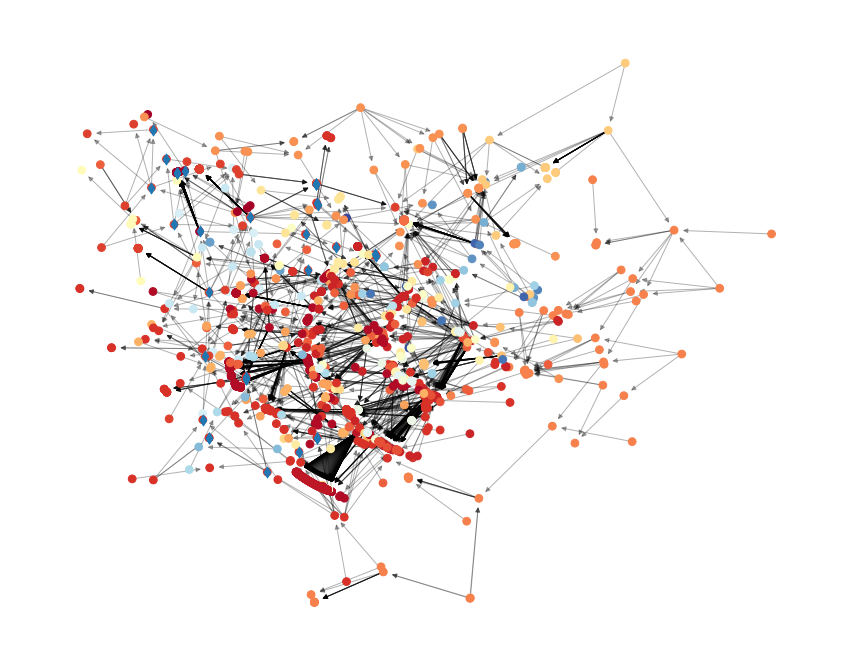

In [283]:
# That big light blue blob might be our winner cluster.
#nx.draw(L, with_labels=True, node_color=df['Greedy_Mod'], cmap=plt.cm.Set1, node_size=1500)

pos = nx.kamada_kawai_layout(L)  # compute graph layout
plt.figure(figsize=(15, 12))  # image is 8 x 8 inches
plt.axis('off')
nx.draw_networkx_nodes(L, pos, node_size=60, cmap=plt.cm.RdYlBu, node_color=list(df['Greedy_Mod'].values))
nx.draw_networkx_nodes(L, pos,
                       nodelist=list(df.loc[((df['Chain_Loc']=='3_Descendant') & (df['_node_type']=='Process'))]['NodeID'].values),
                       node_size=60, node_shape='d',
                       )
nx.draw_networkx_edges(L, pos, alpha=0.3)
plt.savefig("cluster4_boundaries_kamada_kawai_layout.png") # save as png
plt.show(L)

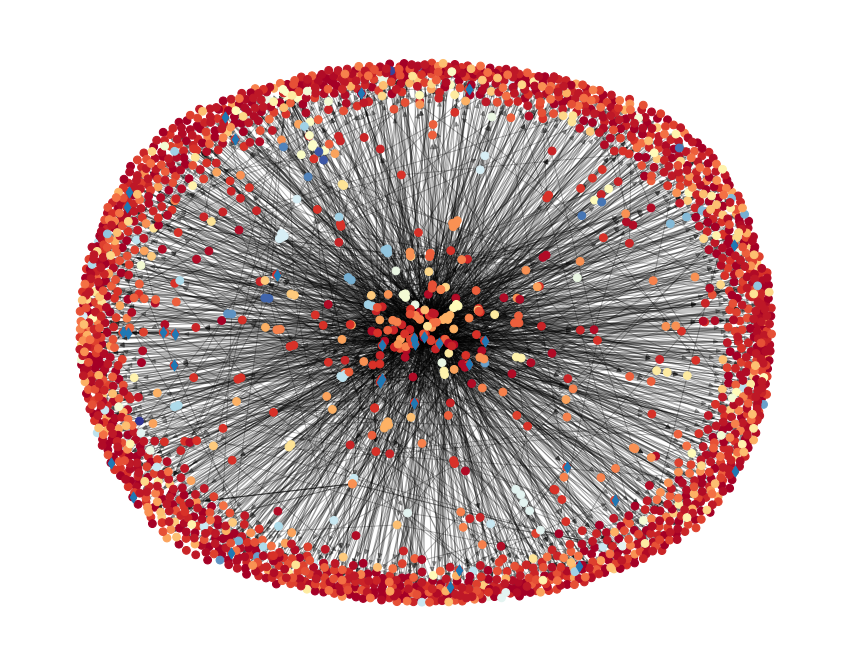

In [284]:
pos = nx.spring_layout(L)  # compute graph layout
plt.figure(figsize=(15, 12))  # image is 8 x 8 inches
plt.axis('off')
nx.draw_networkx_nodes(L, pos, node_size=60, cmap=plt.cm.RdYlBu, node_color=list(df['Greedy_Mod'].values))
nx.draw_networkx_nodes(L, pos,
                       nodelist=list(df.loc[((df['Chain_Loc']=='3_Descendant') & (df['_node_type']=='Process'))]['NodeID'].values),
                       node_size=60, node_shape='d',
                       )
nx.draw_networkx_edges(L, pos, alpha=0.3)
plt.savefig("cluster4_boundaries_spring_layout.png") # save as png
plt.show(L)

In [278]:
df.loc[((df['Chain_Loc']=='3_Descendant') & (df['_node_type']=='Process'))]['NodeID'].values

array([  921841195325485663,  6203651021994293047, -3493091076694682094,
       -3966909180019406072, -6794186510879566337, -3365133265055905318,
       -7955892696165547426,  8481317032775075258,  7342561282071972067,
       -7664972390685160985,  1482523024920771362, -6669213522355045370,
        5017866103384864373, -3370503530581810414,  2432642807750394981,
       -3353415236331243753, -6238030358833295701,   297909835174201098,
        1358271799635070058, -2967269277251100101, -1141707068660541617,
       -9141234886974006197,  4031410057117250989,  2004623612320274083,
        4713874323430228618,  1604182202146040386, -3951208537282705845,
       -1923465199735535609,  5589782681391767515,  5537223495991493050,
       -6007222413974927647, -5556197108945370946,  6931958526547803557])

In [280]:
df['Greedy_Mod'].values

array([11, 11, 11, ..., 35,  0,  9])

In [151]:
#df['DirectedNodeID'] =  df['NodeID'].apply(lambda x: (translate_undirected_to_directed(H, I, x)[0]))

In [152]:
# Orig_label already has it..... booo.
df

NodeID _node_type _node_class                   _display   _color  \
0          0    Process  SysMonProc                svchost.exe  #FF0000   
1          1    Process  SysMonProc              taskhostw.exe  #FF0000   
2          2    Process  SysMonProc               gpupdate.exe  #FF0000   
3          3    Process  SysMonProc              taskhostw.exe  #FF0000   
4          4    Process  SysMonProc              taskhostw.exe  #FF0000   
...      ...        ...         ...                        ...      ...   
1970    1970       File        File                   smss.exe  #3CB371   
1971    1971       File        File  SecurityHealthService.exe  #3CB371   
1972    1972       File        File               services.exe  #3CB371   
1973    1973       File        File              accesschk.exe  #3CB371   
1974    1974       File        File                LogonUI.exe  #3CB371   

               Orig_Label                            process_guid  \
0     5560320793766324432  {47ab858c-cadc-5eac-2200-000000000400}   
1    -5098513601814409719  {47ab858c-e589-5eac-f803-000000000400}   
2      568672525942215723  {47ab858c-e296-5eac-c803-000000000400}   
3     2723077553381010090  {47ab858c-e2d4-5eac-cd03-000000000400}   
4     9075240013458189115  {47ab858c-e37a-5eac-e003-000000000400}   
...                   ...                                     ...   
1970  6378367092892083621                                     NaN   
1971  7426411077127710128                                     NaN   
1972  8630116075230084718                                     NaN   
1973 -6023629865686692145                                     NaN   
1974  4346298866659103320                                     NaN   

                        host  process_id                          user  \
0     SCRANTON.dmevals.local      1448.0                          None   
1     SCRANTON.dmevals.local      8288.0               DMEVALS\pbeesly   
2     SCRANTON.dmevals.local       760.0  NT AUTHORITY\NETWORK SERVICE   
3     SCRANTON.dmevals.local      8532.0               DMEVALS\pbeesly   
4     SCRANTON.dmevals.local      1548.0               DMEVALS\pbeesly   
...                      ...         ...                           ...   
1970  SCRANTON.dmevals.local         NaN                           NaN   
1971  SCRANTON.dmevals.local         NaN                           NaN   
1972  SCRANTON.dmevals.local         NaN                           NaN   
1973  SCRANTON.dmevals.local         NaN                           NaN   
1974  SCRANTON.dmevals.local         NaN                           NaN   

      process_image   process_image_path                   command_line  \
0       svchost.exe  C:\Windows\System32                           None   
1     taskhostw.exe  C:\Windows\System32  taskhostw.exe Install $(Arg0)   
2      gpupdate.exe  C:\Windows\System32  gpupdate.exe /target:computer   
3     taskhostw.exe  C:\Windows\System32  taskhostw.exe Install $(Arg0)   
4     taskhostw.exe  C:\Windows\System32            taskhostw.exe Event   
...             ...                  ...                            ...   
1970            NaN                  NaN                            NaN   
1971            NaN                  NaN                            NaN   
1972            NaN                  NaN                            NaN   
1973            NaN                  NaN                            NaN   
1974            NaN                  NaN                            NaN   

                                                                                                                                                                                                                            hashes  \
0                                                                                                                                                                                                                               {}   
1     {'sha1': '9245F36AA7

In [ ]:
translate_undirected_to_directed(H, I, 1342)

In [147]:
H.node[7308943545932794671]

{'properties': {'process_guid': '{47ab858c-e13c-5eac-a903-000000000400}',
  'host': 'SCRANTON.dmevals.local',
  'process_id': 8524,
  'user': nan,
  'process_image': 'â€®cod.3aka3.scr',
  'process_image_path': 'C:\\ProgramData\\victim',
  'command_line': '"C:\\ProgramData\\victim\\â€®cod.3aka3.scr" /S',
  'hashes': {'sha1': '4B7FA56A4E85F88B98D11A6E018698AE3FBA5E62',
   'md5': '9D1C5EF38E6073661C74660B3A71A76E',
   'sha256': '0DF38A55D940F498478EB03683C94D4584236E100125B526A67650BA54DF4AE4',
   'imphash': 'F00447512A354E59D39D2818AABA4A17'},
  'process_path': 'C:\\ProgramData\\victim\\â€®cod.3aka3.scr'},
 '_node_type': 'Process',
 '_node_class': 'SysMonProc',
 '_display': 'â€®cod.3aka3.scr',
 '_color': '#FF0000'}

In [139]:
type(malicious_root_ancestor) == int

True

In [111]:
#pd.DataFrame(c_degree)
df_centrality = pd.DataFrame({'Centrality_Degree': c_degree}, index=c_degree.keys())
#df_centrality['CommandLine'] =  df_centrality.index.apply(lambda x: (x)) 
#df_centrality['CommandLine'] =  df_centrality.index.map(lambda x: (x)) 
df_centrality = df_centrality.reset_index().rename(columns={"index" : "NodeID"})
df_centrality['CommandLine'] =  df_centrality['NodeID'].apply(lambda x: (
    if 'process_guid' in I.node[i]['properties'].keys():
        proc_nodes_guids.append(H.node[i]['properties']['process_guid'])
    I.node[x]['properties']['command_line'])
                                                             ) 

df_centrality

KeyError: 'command_line'

In [101]:
df_centrality.index

Int64Index([   0,    1,    2,    3,    4,    5,    6,    7,    8,    9,
            ...
            1965, 1966, 1967, 1968, 1969, 1970, 1971, 1972, 1973, 1974],
           dtype='int64', length=1975)

In [97]:
c_degree

{0: 0.003546099290780142,
 1: 0.0010131712259371835,
 2: 0.0015197568389057753,
 3: 0.0010131712259371835,
 4: 0.0010131712259371835,
 5: 0.1707193515704154,
 6: 0.0010131712259371835,
 7: 0.050658561296859174,
 8: 0.0015197568389057753,
 9: 0.0010131712259371835,
 10: 0.002026342451874367,
 11: 0.010131712259371834,
 12: 0.014184397163120569,
 13: 0.011144883485309018,
 14: 0.004052684903748734,
 15: 0.0010131712259371835,
 16: 0.0010131712259371835,
 17: 0.0010131712259371835,
 18: 0.0010131712259371835,
 19: 0.0015197568389057753,
 20: 0.0010131712259371835,
 21: 0.0010131712259371835,
 22: 0.0010131712259371835,
 23: 0.0010131712259371835,
 24: 0.0010131712259371835,
 25: 0.0010131712259371835,
 26: 0.002026342451874367,
 27: 0.009118541033434652,
 28: 0.0010131712259371835,
 29: 0.0010131712259371835,
 30: 0.0010131712259371835,
 31: 0.0010131712259371835,
 32: 0.0010131712259371835,
 33: 0.0010131712259371835,
 34: 0.0010131712259371835,
 35: 0.0010131712259371835,
 36: 0.0010131

In [100]:
len(proc_nodes_nodeIDs)

35

In [97]:
len(file_nodes)

452

In [98]:
len(file_nodes_nodeIDs)

452

In [101]:
len(ip_nodes)

7

In [102]:
len(ip_nodes_nodeIDs)

7

In [106]:
for i in c_degree_sorted.items():
    if i[0] in file_nodes_nodeIDs:
        print(i)
        print(I.node[i[0]])
        print("")

(417, 0.0025329280648429585)
{'properties': {'host': None, 'file_path': 'C:\\Users\\pbeesly\\AppData\\Local\\Microsoft\\Windows\\PowerShell', 'file_name': 'ModuleAnalysisCache', 'full_path': 'C:\\Users\\pbeesly\\AppData\\Local\\Microsoft\\Windows\\PowerShell\\ModuleAnalysisCache', 'extension': None, 'hashes': {}}, '_node_type': 'File', '_node_class': 'File', '_display': 'ModuleAnalysisCache', '_color': '#3CB371', 'Orig_Label': -3133912620500497145}

(594, 0.0025329280648429585)
{'properties': {'host': None, 'file_path': 'C:\\Users\\pbeesly\\AppData\\Local\\Microsoft\\Windows\\PowerShell', 'file_name': 'StartupProfileData-Interactive', 'full_path': 'C:\\Users\\pbeesly\\AppData\\Local\\Microsoft\\Windows\\PowerShell\\StartupProfileData-Interactive', 'extension': None, 'hashes': {}}, '_node_type': 'File', '_node_class': 'File', '_display': 'StartupProfileData-Interactive', '_color': '#3CB371', 'Orig_Label': -3033692600434244681}

(733, 0.0010131712259371835)
{'properties': {'host': None, 

In [93]:
for i in H.nodes():
    print(H.node[i])

{'properties': {'host': None, 'file_path': 'C:\\Users\\pbeesly\\Downloads\\SysinternalsSuite', 'file_name': 'ctrl2cap.nt4.sys', 'full_path': 'C:\\Users\\pbeesly\\Downloads\\SysinternalsSuite\\ctrl2cap.nt4.sys', 'extension': None, 'hashes': {}}, '_node_type': 'File', '_node_class': 'File', '_display': 'ctrl2cap.nt4.sys', '_color': '#3CB371'}
{'properties': {'host': 'SCRANTON.dmevals.local', 'file_path': 'C:\\Windows', 'file_name': 'explorer.exe', 'full_path': 'C:\\Windows\\explorer.exe', 'extension': None, 'hashes': {'sha1': 'C893CF07E5F65749CD66E17D9523638B132C87B2', 'md5': 'F7DC8A74E30E08B9510380274CFB9288', 'sha256': 'C5E88D778C0B118D49BEF467ED059C09B61DEEA505D2A3D5CA1DCC0A5CDF752F', 'imphash': 'FE6F775DD0C72FFD106F56930C60A452'}}, '_node_type': 'File', '_node_class': 'File', '_display': 'explorer.exe', '_color': '#3CB371'}
{'properties': {'host': None, 'file_path': 'C:\\Users\\pbeesly\\Downloads\\__MACOSX\\SysinternalsSuite', 'file_name': '._junction64.exe', 'full_path': 'C:\\Users\

In [ ]:
for i in c_degree_sorted.items():
    if i[0] in file_nodes_nodeIDs:
        print(i)
        print(I.node[i[0]])
        print("")

## Test Karate Club

In [35]:
from karateclub import LabelPropagation

model = LabelPropagation()
model.fit(H)
cluster_membership = model.get_memberships()

In [36]:
cluster_membership

{744: 789,
 298: 311,
 57: 991,
 812: 789,
 1711: 1566,
 431: 419,
 254: 246,
 1730: 1566,
 1200: 1205,
 1175: 1905,
 970: 1336,
 1130: 1126,
 1293: 927,
 608: 419,
 452: 419,
 1116: 1103,
 409: 419,
 315: 1832,
 870: 859,
 1474: 139,
 1361: 1356,
 1640: 1566,
 927: 927,
 1542: 1566,
 313: 1302,
 1556: 1566,
 300: 311,
 1872: 1356,
 597: 419,
 1805: 1832,
 1725: 1566,
 1579: 1566,
 1641: 1566,
 96: 991,
 272: 1845,
 1768: 13,
 1478: 1477,
 1774: 128,
 1366: 1356,
 553: 419,
 1592: 1566,
 1710: 1566,
 1419: 1407,
 276: 278,
 102: 991,
 1619: 1566,
 1740: 128,
 423: 419,
 920: 1302,
 552: 419,
 572: 419,
 1804: 1832,
 1874: 128,
 1188: 602,
 834: 852,
 1558: 1566,
 1832: 1832,
 687: 687,
 441: 419,
 1943: 1209,
 550: 419,
 442: 419,
 1381: 1356,
 1724: 1566,
 1721: 1566,
 862: 859,
 268: 1845,
 1732: 128,
 1517: 1566,
 1916: 1905,
 509: 419,
 1904: 1905,
 627: 419,
 438: 419,
 1547: 1566,
 138: 138,
 796: 789,
 194: 232,
 758: 789,
 258: 246,
 902: 895,
 1230: 1226,
 1847: 1302,
 551: 41

In [37]:
cluster_membership = [cluster_membership[node] for node in range(len(cluster_membership))]

In [38]:
cluster_membership

[11,
 696,
 184,
 696,
 696,
 5,
 696,
 128,
 991,
 991,
 991,
 11,
 12,
 13,
 14,
 991,
 991,
 991,
 991,
 991,
 991,
 991,
 991,
 991,
 991,
 991,
 991,
 27,
 991,
 991,
 991,
 991,
 991,
 991,
 991,
 991,
 991,
 991,
 991,
 991,
 991,
 991,
 991,
 991,
 44,
 991,
 991,
 991,
 48,
 991,
 991,
 51,
 991,
 991,
 991,
 55,
 991,
 991,
 991,
 991,
 991,
 991,
 991,
 991,
 991,
 991,
 66,
 991,
 121,
 991,
 991,
 991,
 991,
 991,
 991,
 991,
 991,
 991,
 991,
 991,
 991,
 991,
 991,
 991,
 991,
 991,
 991,
 991,
 991,
 991,
 991,
 991,
 991,
 991,
 991,
 991,
 991,
 991,
 991,
 991,
 100,
 991,
 991,
 991,
 991,
 991,
 991,
 11,
 696,
 696,
 696,
 696,
 696,
 696,
 696,
 1845,
 316,
 316,
 118,
 119,
 120,
 121,
 157,
 1845,
 1845,
 125,
 1845,
 1845,
 128,
 991,
 130,
 991,
 232,
 991,
 1953,
 232,
 236,
 991,
 138,
 139,
 991,
 1346,
 991,
 991,
 991,
 991,
 991,
 991,
 128,
 128,
 150,
 157,
 157,
 157,
 157,
 157,
 157,
 157,
 1952,
 150,
 160,
 162,
 162,
 162,
 162,
 160,
 160,
 197